In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange_ids = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
imp_type

impression type  imp_type_id
0          display            1
1            video            2
2           native            4
3     native video            8
4   rewarded video           16
5              IBV           32
6  rewarded banner           64

In [3]:
start_dt = '2021-04-01'
end_dt = '2021-04-26'

In [4]:
# format helper functions

def color_nan_white(val):
    if np.isnan(val):
        return 'color: white'

def color_nan_white_background(val):
    """Color the nan cell background white"""
    if np.isnan(val):
        return 'background-color: white'
    
def color_format(x, format_str = "{{:.2f}}"):
    return x.style.format(format_str).background_gradient(cmap=cm, axis = 1).applymap(lambda x: color_nan_white(x)).applymap(lambda x: color_nan_white_background(x))

(1) Why aren't we buying as much on AdColony? 

(2) High Level SSP Comparison for Bid Prices, Clearing Prices, Bundle/Ad Size Overlap

(3) CTR/IPM Comparisons between Top SSPs? 

(4) For the same bundles/ad sizes across SSPs how do the CTR/IPMs track?

(5) % of Inventory coming as first price? (All?)

(6) % of Bid Requests/Spend from LAT vs Non LAT 


## 1. Why aren't we buying as much on Adcolony?

See analysis below. The impression -> install metrics are strong, and the bid price is very high, but two reasons stand out:
1. *No Banner Inventory*: Globally, ~80% of our impressions are served on banners, but there are 0 banner impressions for AdColony in the time range. I would assume that there are inclinations or reasons that our bidder does not favor interstitial spend.
2. *Small Interstitial impressions*: Even the insterstitial impressions we have won are very small compared to the high avg bid price. We cannot diagnose the reason without bid data, but it seems we aren't getting the bid requests we should be, considering our previous experiences with AdColony.

## 2. High Level SSP Comparison for Bid Prices, Clearing Prices, Bundle/Ad Size Overlap

In [18]:
by_exchange_auction = bigquery_client.query(f"""
select
    p.bundle
    , case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , attr.exchange_id
    , attr.ad_size
    , attr.ad_type
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
    , sum(case when event_type = 'clear' then bid_price else 0 end)*16 as total_bid_price
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16 as total_settlement_price
from stats.rows attr 
join metadata.apps p
    on p.app_id = attr.hosting_app_id
where 
    attr.date >= '{start_dt}'
    and attr.date <= '{end_dt}'
    and left(attr.id,1) = '0'
group by 1,2,3,4,5
""").to_dataframe()
by_exchange_auction = pd.merge(by_exchange_auction, exchange_ids, left_on = 'exchange_id', right_on = 'exchange_id')
by_exchange_auction

bundle buyer  exchange_id   ad_size ad_type  \
0            com.bi.slots.immortality   RON           18   640x100  banner   
1       sudoku.puzzle.free.game.brain   RON           18   640x100  banner   
2                com.easygames.resize   RON           18   640x100  banner   
3            com.Born2Play.StackyDash   RON           18  1200x628  banner   
4                  com.ketchapp.stack   RON           18   640x100  banner   
...                               ...   ...          ...       ...     ...   
147660        com.peoplefun.wordcross   RON           24  768x1024   inter   
147661                 com.harvest.io    DT           24  768x1024   inter   
147662          com.tatemgames.iceage   RON           24  768x1024   inter   
147663                 com.oprah.game    DT           24  768x1024   inter   
147664        com.spcomes.fruitforest    DT           24  768x1024   inter   

        impressions  spend  total_bid_price  total_settlement_price  \
0                16    0.0         7.834640                   7.120   
1              1856    0.0       210.604304                 188.704   
2                16    0.0         5.094400                   4.720   
3                64    0.0        16.039872                  14.904   
4                16    0.0         1.035040                   1.000   
...             ...    ...              ...                     ...   
147660         3056    0.0     37159.620608               37251.360   
147661           32    0.0      1428.043792                1428.048   
147662           16    0.0       374.445088                 374.448   
147663           64    0.0       975.029008                 975.024   
147664           48    0.0       222.567552                 222.576   

       exchange_name  
0          PubNative  
1          PubNative  
2          PubNative  
3          PubNative  
4          PubNative  
...              ...  
147660      AdColony  
147661      AdColony  
147662      AdColony  
147663      AdColony  
147664      AdColony  

[147665 rows x 10 columns]

In [62]:
by_exchange = by_exchange_auction.pivot_table(values = ['spend','total_bid_price','total_settlement_price','impressions'], index = 'exchange_name', aggfunc = np.sum)
top_exchanges = by_exchange.sort_values('spend', ascending = False).index[:10].to_list()
by_exchange['avg_bid_price'] = by_exchange['total_bid_price']/by_exchange['impressions']
by_exchange['avg_settlement_price'] = by_exchange['total_settlement_price']/by_exchange['impressions']
by_exchange.sort_values('spend', ascending = False, inplace = True)
by_exchange['cum_sov'] = by_exchange['spend'].cumsum()/by_exchange['spend'].sum()

by_exchange_formatted = by_exchange[['impressions', 'spend', 'avg_bid_price', 'avg_settlement_price','cum_sov']].copy()
format_mapping = {'avg_bid_price':'${0:.2f}'
                  ,'avg_settlement_price':'${0:.2f}'
                  ,'cum_sov':'{0:.0f}%'
                  ,'spend':'${0:,.0f}'
                 }
by_exchange_formatted['cum_sov'] = (100*by_exchange['cum_sov'])
by_exchange_formatted = by_exchange_formatted.style.format(format_mapping).background_gradient(cmap=cm, subset = ['avg_bid_price','avg_settlement_price'])
by_exchange_formatted


In [20]:
by_exchange_dt = by_exchange_auction[by_exchange_auction.buyer == 'DT'].pivot_table(values = ['spend','total_bid_price','total_settlement_price','impressions'], index = 'exchange_name', aggfunc = np.sum)
top_exchanges_dt = by_exchange.sort_values('spend', ascending = False).index[:10].to_list()
by_exchange_dt['avg_bid_price'] = by_exchange_dt['total_bid_price']/by_exchange_dt['impressions']
by_exchange_dt['avg_settlement_price'] = by_exchange_dt['total_settlement_price']/by_exchange_dt['impressions']
by_exchange_dt.sort_values('spend', ascending = False, inplace = True)
by_exchange_dt['cum_sov'] = by_exchange_dt['spend'].cumsum()/by_exchange_dt['spend'].sum()

by_exchange_formatted = by_exchange_dt[['impressions', 'spend', 'avg_bid_price', 'avg_settlement_price','cum_sov']].copy()
format_mapping = {'avg_bid_price':'${0:.2f}'
                  ,'avg_settlement_price':'${0:.2f}'
                  ,'cum_sov':'{0:.0f}%'
                  ,'spend':'${0:,.0f}'
                 }
# by_exchange_formatted[['avg_bid_price','avg_settlement_price']] = by_exchange_dt[['avg_bid_price','avg_settlement_price']]
by_exchange_formatted['cum_sov'] = (100*by_exchange_dt['cum_sov'])
by_exchange_formatted = by_exchange_formatted.style.format(format_mapping).background_gradient(cmap=cm, subset = ['avg_bid_price','avg_settlement_price'])
by_exchange_formatted


In [21]:
by_exchange_type = by_exchange_auction.pivot_table(values = ['spend','total_bid_price','total_settlement_price','impressions'], index = 'exchange_name', columns = 'ad_type', aggfunc = np.sum)
by_exchange_type[('avg_bid_price','banner')] = by_exchange_type[('total_bid_price','banner')]/by_exchange_type[('impressions','banner')]
by_exchange_type[('avg_settlement_price','banner')] = by_exchange_type[('total_settlement_price','banner')]/by_exchange_type[('impressions','banner')]
by_exchange_type[('avg_bid_price','inter')] = by_exchange_type[('total_bid_price','inter')]/by_exchange_type[('impressions','inter')]
by_exchange_type[('avg_settlement_price','inter')] = by_exchange_type[('total_settlement_price','inter')]/by_exchange_type[('impressions','inter')]

exchange_type_summary = by_exchange_type[by_exchange_type.columns[2:4].to_list() + by_exchange_type.columns[8:].to_list()]
exchange_type_summary.columns = ['spend - banner','spend - inter','avg_bid_price - banner','avg_settlement_price - banner','avg_bid_price - inter','avg_settlement_price - inter']
exchange_type_summary = by_exchange.join(exchange_type_summary)
exchange_type_summary['banner_sov'] = exchange_type_summary['spend - banner']/(exchange_type_summary['spend - banner'] + exchange_type_summary['spend - inter'])

exchange_type_summary_formatted = exchange_type_summary.loc[:,['impressions','spend','banner_sov','avg_bid_price - banner','avg_bid_price - inter','avg_settlement_price - banner','avg_settlement_price - inter']].sort_values('spend', ascending = False)
exchange_type_summary_formatted[['banner_sov']] = exchange_type_summary_formatted[['banner_sov']].mul(100)
format_mapping = {'avg_bid_price - banner':'${0:.2f}'
                  ,'avg_bid_price - inter':'${0:.2f}'
                  ,'avg_settlement_price - banner':'${0:.2f}'
                  ,'avg_settlement_price - inter':'${0:.2f}'
                  ,'spend':'${0:,.0f}'
                  ,'banner_sov':'{0:.0f}%'
                  ,'impressions':'{0:,.0f}'
                 }

exchange_type_summary_formatted = exchange_type_summary_formatted.style.format(format_mapping).background_gradient(cmap=cm, subset = ['avg_bid_price - banner','avg_bid_price - inter','avg_settlement_price - banner','avg_settlement_price - inter'])
exchange_type_summary_formatted = exchange_type_summary_formatted.applymap(lambda x:color_nan_white(x)).applymap(lambda x:color_nan_white_background(x))
exchange_type_summary_formatted

In [22]:
by_exchange_type_dt = by_exchange_auction[by_exchange_auction.buyer == 'DT'].pivot_table(values = ['spend','total_bid_price','total_settlement_price','impressions'], index = 'exchange_name', columns = 'ad_type', aggfunc = np.sum)
by_exchange_type_dt[('avg_bid_price','banner')] = by_exchange_type_dt[('total_bid_price','banner')]/by_exchange_type_dt[('impressions','banner')]
by_exchange_type_dt[('avg_settlement_price','banner')] = by_exchange_type_dt[('total_settlement_price','banner')]/by_exchange_type_dt[('impressions','banner')]
by_exchange_type_dt[('avg_bid_price','inter')] = by_exchange_type_dt[('total_bid_price','inter')]/by_exchange_type_dt[('impressions','inter')]
by_exchange_type_dt[('avg_settlement_price','inter')] = by_exchange_type_dt[('total_settlement_price','inter')]/by_exchange_type_dt[('impressions','inter')]

exchange_type_summary_dt = by_exchange_type_dt[by_exchange_type_dt.columns[2:4].to_list() + by_exchange_type_dt.columns[8:].to_list()]
exchange_type_summary_dt.columns = ['spend - banner','spend - inter','avg_bid_price - banner','avg_settlement_price - banner','avg_bid_price - inter','avg_settlement_price - inter']
exchange_type_summary_dt = by_exchange_dt.join(exchange_type_summary_dt)
exchange_type_summary_dt['banner_sov'] = exchange_type_summary_dt['spend - banner']/(exchange_type_summary_dt['spend - banner'] + exchange_type_summary_dt['spend - inter'])

exchange_type_summary_dt_formatted = exchange_type_summary_dt.loc[:,['impressions','spend','banner_sov','avg_bid_price - banner','avg_bid_price - inter','avg_settlement_price - banner','avg_settlement_price - inter']].sort_values('spend', ascending = False)
exchange_type_summary_dt_formatted[['banner_sov']] = exchange_type_summary_dt_formatted[['banner_sov']].mul(100)
format_mapping = {'avg_bid_price - banner':'${0:.2f}'
                  ,'avg_bid_price - inter':'${0:.2f}'
                  ,'avg_settlement_price - banner':'${0:.2f}'
                  ,'avg_settlement_price - inter':'${0:.2f}'
                  ,'spend':'${0:,.0f}'
                  ,'banner_sov':'{0:.0f}%'
                 }

exchange_type_summary_dt_formatted = exchange_type_summary_dt_formatted.style.format(format_mapping).background_gradient(cmap=cm, subset = ['avg_bid_price - banner','avg_bid_price - inter','avg_settlement_price - banner','avg_settlement_price - inter'])
exchange_type_summary_dt_formatted = exchange_type_summary_dt_formatted.applymap(lambda x: color_nan_white(x)).applymap(lambda x: color_nan_white_background(x))
exchange_type_summary_dt_formatted


In [23]:
plt.scatter('banner_sov','avg_bid_price', data = exchange_type_summary)

In [27]:
df_size_bnd_overlap = bigquery_client.query(f"""
select
    p.bundle
    , attr.ad_size
    , attr.exchange_id
    , case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
from stats.rows attr 
join metadata.apps p
    on p.app_id = attr.hosting_app_id
where 
    attr.date >= '{start_dt}'
    and attr.date <= '{end_dt}'
    and left(attr.id,1) = '0'
group by 1,2,3,4""").to_dataframe()
df_size_bnd_overlap = pd.merge(df_size_bnd_overlap, exchange_ids, left_on = 'exchange_id', right_on = 'exchange_id')

In [28]:
top_sizes = df_size_bnd_overlap.groupby('ad_size')['spend'].sum().sort_values(ascending = False).index[:10]
pvt = df_size_bnd_overlap.pivot_table(values = 'spend', index = 'exchange_name', columns = 'ad_size', aggfunc = np.sum, margins = True)
overlap_bysize = 100*pvt.div(pvt.iloc[:,-1], axis=0)
color_format(overlap_bysize.loc[top_exchanges,top_sizes],'{0:.0f}%')

In [29]:
top_sizes_dt = df_size_bnd_overlap[df_size_bnd_overlap.buyer == 'DT'].groupby('ad_size')['spend'].sum().sort_values(ascending = False).index[:10]
pvt = df_size_bnd_overlap[df_size_bnd_overlap.buyer == 'DT'].pivot_table(values = 'spend', index = 'exchange_name', columns = 'ad_size', aggfunc = np.sum, margins = True)
overlap_bysize = 100*pvt.div(pvt.iloc[:,-1], axis=0)
color_format(overlap_bysize.loc[overlap_bysize.index.isin(top_exchanges_dt),top_sizes_dt],'{0:.0f}%')

In [30]:
top_bundles = df_size_bnd_overlap.groupby('bundle')['spend'].sum().sort_values(ascending = False).index[:50]
pvt = df_size_bnd_overlap.pivot_table(values = 'spend', index = 'bundle', columns = 'exchange_name', aggfunc = np.sum, margins = True)
pvt.sort_values('All', ascending = False, inplace = True)
overlap_bybnd = 100*pvt.div(pvt.iloc[:,-1], axis=0)[1:] # Remove the "All" row
color_format(overlap_bybnd.loc[top_bundles, top_exchanges],"{:.0f}%")

In [31]:
top_bundles_dt = df_size_bnd_overlap[df_size_bnd_overlap.buyer == 'DT'].groupby('bundle')['spend'].sum().sort_values(ascending = False).index[:50]
pvt = df_size_bnd_overlap[df_size_bnd_overlap.buyer == 'DT'].pivot_table(values = 'spend', index = 'bundle', columns = 'exchange_name', aggfunc = np.sum, margins = True)
pvt.sort_values('All', ascending = False, inplace = True)
overlap_bybnd = 100*pvt.div(pvt.iloc[:,-1], axis=0)[1:] # Remove the "All" row
top_exchange_cols = overlap_bybnd.columns[[x in top_exchanges_dt for x in overlap_bybnd.columns]]
color_format(overlap_bybnd.loc[top_bundles_dt, top_exchange_cols],"{:.0f}%")

## 3. CTR/IPM Comparisons between Top SSPs?

In [32]:
by_app = bigquery_client.query(f"""
select
    p.bundle
    , attr.ad_type
    , attr.exchange_id
    , case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs 
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend 
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost 
from stats.rows attr 
join metadata.apps p
    on p.app_id = attr.hosting_app_id 
where 
    date >= '{start_dt}'
    and date <= '{end_dt}' 
    and left(attr.id,1) = '0'
group by 1,2,3,4
""").to_dataframe()

In [33]:
by_app = pd.merge(by_app, exchange_ids, left_on = 'exchange_id', right_on = 'exchange_id')
by_app

bundle ad_type  exchange_id buyer  \
0                                      1193508329  banner           50   RON   
1                                       412412148  banner           50   RON   
2                                  com.viber.voip  banner           50   RON   
3                  com.surpax.ledflashlight.panel   inter           50   RON   
4                             com.fiogonia.hearts  banner           50   RON   
...                                           ...     ...          ...   ...   
108018                                 1523984150  banner           56   RON   
108019          com.anxiousottergames.spacefarmer   inter           56    DT   
108020             com.wallpaper.sonic_hedgehog98  banner           56   RON   
108021     anime.paint.kid.tap.coloring.by.number  banner           56   RON   
108022  com.root.clean.boost.explorer.filemanager   inter           56    DT   

        impressions  clicks  installs   spend       cost exchange_name  
0                48       0         0     0.0   0.011680        MailRu  
1              3600       0         0     0.0   0.522080        MailRu  
2                16       0         0     0.0   0.020640        MailRu  
3            744896   43232      2880  1033.6  18.758080        MailRu  
4                32       0         0     0.0   0.009600        MailRu  
...             ...     ...       ...     ...        ...           ...  
108018           16       0         0     0.0   0.010048       Algorix  
108019           16       0         0     0.0   0.393568       Algorix  
108020           16       0         0     0.0   0.006400       Algorix  
108021           16       0         0     0.0   0.001824       Algorix  
108022           16       0         0     0.0   0.002464       Algorix  

[108023 rows x 10 columns]

In [34]:
by_exchange = by_app.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'exchange_name', aggfunc = np.sum)
by_exchange['ctr'] = by_exchange['clicks']/by_exchange['impressions']
by_exchange['ir'] = by_exchange['installs']/by_exchange['clicks']
by_exchange['ipm'] = 1000*by_exchange['installs']/by_exchange['impressions']
by_exchange['cpi'] = by_exchange['spend']/by_exchange['installs']
by_exchange['cpm'] = 1000*by_exchange['cost']/by_exchange['impressions']
by_exchange['sov'] = by_exchange['spend']/by_exchange['spend'].sum()
by_exchange.sort_values('spend', ascending = False, inplace = True)
format_mapping = {'ctr':'{0:.1f}%'
                  ,'ir':'{0:.1f}%'
                  ,'ipm':'{0:.2f}'
                  ,'cpi':'${:,.2f}'
                  ,'cost':'${:,.0f}'
                  ,'spend':'${:,.0f}'
                  ,'sov':'{0:.0f}%'
                  ,'impressions':'{:,.0f}'
                  ,'clicks':'{:,.0f}'
                  ,'installs':'{:,.0f}'
                 }
by_exchange_formatted = by_exchange.loc[top_exchanges,['impressions','clicks','ctr','installs','ir','ipm','cpi','cost','spend','sov']]
by_exchange_formatted[['ctr','ir','sov']] = by_exchange[['ctr','ir','sov']].mul(100)
by_exchange_formatted = by_exchange_formatted.style.format(format_mapping).background_gradient(cmap=cm, axis = 0, subset = ['ctr','ir','ipm','cpi','sov'])
by_exchange_formatted


In [35]:
by_exchange = by_app[by_app.buyer == 'DT'].pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'exchange_name', aggfunc = np.sum)
by_exchange['ctr'] = by_exchange['clicks']/by_exchange['impressions']
by_exchange['ir'] = by_exchange['installs']/by_exchange['clicks']
by_exchange['ipm'] = 1000*by_exchange['installs']/by_exchange['impressions']
by_exchange['cpi'] = by_exchange['spend']/by_exchange['installs']
by_exchange['cpm'] = 1000*by_exchange['cost']/by_exchange['impressions']
by_exchange['sov'] = by_exchange['spend']/by_exchange['spend'].sum()
by_exchange.sort_values('spend', ascending = False, inplace = True)
format_mapping = {'ctr':'{0:.1f}%'
                  ,'ir':'{0:.1f}%'
                  ,'ipm':'{0:.2f}'
                  ,'cpi':'${:,.2f}'
                  ,'cost':'${:,.0f}'
                  ,'spend':'${:,.0f}'
                  ,'sov':'{0:.0f}%'
                  ,'impressions':'{:,.0f}'
                  ,'clicks':'{:,.0f}'
                  ,'installs':'{:,.0f}'
                 }
by_exchange_formatted = by_exchange.loc[by_exchange.index.isin(top_exchanges_dt),['impressions','clicks','ctr','installs','ir','ipm','cpi','cost','spend','sov']]
by_exchange_formatted[['ctr','ir','sov']] = by_exchange[['ctr','ir','sov']].mul(100)
by_exchange_formatted = by_exchange_formatted.style.format(format_mapping).background_gradient(cmap=cm, axis = 0, subset = ['ctr','ir','ipm','cpi','sov'])
index_dt = by_exchange_formatted.index
by_exchange_formatted


In [36]:
by_exchange = by_app[by_app.ad_type == 'banner'].pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'exchange_name', aggfunc = np.sum)
by_exchange['ctr'] = by_exchange['clicks']/by_exchange['impressions']
by_exchange['ir'] = by_exchange['installs']/by_exchange['clicks']
by_exchange['ipm'] = 1000*by_exchange['installs']/by_exchange['impressions']
by_exchange['cpi'] = by_exchange['spend']/by_exchange['installs']
by_exchange['cpm'] = 1000*by_exchange['cost']/by_exchange['impressions']
by_exchange['sov'] = by_exchange['spend']/by_exchange['spend'].sum()
by_exchange.sort_values('impressions', ascending = False, inplace = True)
format_mapping = {'ctr':'{0:.1f}%'
                  ,'ir':'{0:.1f}%'
                  ,'ipm':'{0:.2f}'
                  ,'cpi':'${:,.2f}'
                  ,'cost':'${:,.0f}'
                  ,'spend':'${:,.0f}'
                  ,'sov':'{0:.0f}%'
                  ,'impressions':'{:,.0f}'
                  ,'clicks':'{:,.0f}'
                  ,'installs':'{:,.0f}'
                 }
by_exchange_formatted = by_exchange.loc[top_exchanges,['impressions','clicks','ctr','installs','ir','ipm','cpi','cost','spend','sov']].copy()
by_exchange_formatted[['ctr','ir','sov']] = by_exchange[['ctr','ir','sov']].mul(100)
by_exchange_formatted = by_exchange_formatted.style.format(format_mapping).background_gradient(cmap=cm, axis = 0, subset = ['ctr','ir','ipm','cpi','sov'])
by_exchange_formatted = by_exchange_formatted.applymap(lambda x:color_nan_white(x)).applymap(lambda x:color_nan_white_background(x))
by_exchange_formatted

In [37]:
by_exchange = by_app[(by_app.ad_type == 'banner') & (by_app.buyer == 'DT')].pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'exchange_name', aggfunc = np.sum)
by_exchange['ctr'] = by_exchange['clicks']/by_exchange['impressions']
by_exchange['ir'] = by_exchange['installs']/by_exchange['clicks']
by_exchange['ipm'] = 1000*by_exchange['installs']/by_exchange['impressions']
by_exchange['cpi'] = by_exchange['spend']/by_exchange['installs']
by_exchange['cpm'] = 1000*by_exchange['cost']/by_exchange['impressions']
by_exchange['sov'] = by_exchange['spend']/by_exchange['spend'].sum()
by_exchange.sort_values('impressions', ascending = False, inplace = True)
format_mapping = {'ctr':'{0:.1f}%'
                  ,'ir':'{0:.1f}%'
                  ,'ipm':'{0:.2f}'
                  ,'cpi':'${:,.2f}'
                  ,'cost':'${:,.0f}'
                  ,'spend':'${:,.0f}'
                  ,'sov':'{0:.0f}%'
                  ,'impressions':'{:,.0f}'
                  ,'clicks':'{:,.0f}'
                  ,'installs':'{:,.0f}'
                 }

by_exchange_formatted = by_exchange.loc[by_exchange.index.isin(top_exchanges_dt),['impressions','clicks','ctr','installs','ir','ipm','cpi','cost','spend','sov']].copy()
by_exchange_formatted[['ctr','ir','sov']] = by_exchange[['ctr','ir','sov']].mul(100)
by_exchange_formatted = by_exchange_formatted.style.format(format_mapping).background_gradient(cmap=cm, axis = 0, subset = ['ctr','ir','ipm','cpi','sov'])
by_exchange_formatted = by_exchange_formatted.applymap(lambda x:color_nan_white(x)).applymap(lambda x:color_nan_white_background(x))
by_exchange_formatted

In [38]:
by_exchange = by_app[by_app.ad_type == 'inter'].pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'exchange_name', aggfunc = np.sum)
by_exchange['ctr'] = by_exchange['clicks']/by_exchange['impressions']
by_exchange['ir'] = by_exchange['installs']/by_exchange['clicks']
by_exchange['ipm'] = 1000*by_exchange['installs']/by_exchange['impressions']
by_exchange['cpi'] = by_exchange['spend']/by_exchange['installs']
by_exchange['cpm'] = 1000*by_exchange['cost']/by_exchange['impressions']
by_exchange['sov'] = by_exchange['spend']/by_exchange['spend'].sum()

format_mapping = {'ctr':'{0:.1f}%'
                  ,'ir':'{0:.1f}%'
                  ,'ipm':'{0:.2f}'
                  ,'cpi':'${:,.2f}'
                  ,'cost':'${:,.0f}'
                  ,'spend':'${:,.0f}'
                  ,'sov':'{0:.0f}%'
                  ,'impressions':'{:,.0f}'
                  ,'clicks':'{:,.0f}'
                  ,'installs':'{:,.0f}'
                 }
by_exchange_formatted = by_exchange.loc[top_exchanges,['impressions','clicks','ctr','installs','ir','ipm','cpi','cost','spend','sov']].copy()
by_exchange_formatted[['ctr','ir','sov']] = by_exchange[['ctr','ir','sov']].mul(100)
by_exchange_formatted['cpi'] = by_exchange_formatted['cpi'].fillna(0)
by_exchange_formatted = by_exchange_formatted.style.format(format_mapping).background_gradient(cmap=cm, axis = 0, subset = ['ctr','ir','ipm','cpi','sov'])
by_exchange_formatted

In [39]:
by_exchange = by_app[(by_app.ad_type == 'inter') & (by_app.buyer == 'DT')].pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'exchange_name', aggfunc = np.sum)
by_exchange['ctr'] = by_exchange['clicks']/by_exchange['impressions']
by_exchange['ir'] = by_exchange['installs']/by_exchange['clicks']
by_exchange['ipm'] = 1000*by_exchange['installs']/by_exchange['impressions']
by_exchange['cpi'] = by_exchange['spend']/by_exchange['installs']
by_exchange['cpm'] = 1000*by_exchange['cost']/by_exchange['impressions']
by_exchange['sov'] = by_exchange['spend']/by_exchange['spend'].sum()

format_mapping = {'ctr':'{0:.1f}%'
                  ,'ir':'{0:.1f}%'
                  ,'ipm':'{0:.2f}'
                  ,'cpi':'${:,.2f}'
                  ,'cost':'${:,.0f}'
                  ,'spend':'${:,.0f}'
                  ,'sov':'{0:.0f}%'
                  ,'impressions':'{:,.0f}'
                  ,'clicks':'{:,.0f}'
                  ,'installs':'{:,.0f}'
                 }
by_exchange_formatted = by_exchange.loc[by_exchange.index.isin(top_exchanges_dt),['impressions','clicks','ctr','installs','ir','ipm','cpi','cost','spend','sov']].copy()
by_exchange_formatted[['ctr','ir','sov']] = by_exchange[['ctr','ir','sov']].mul(100)
by_exchange_formatted['cpi'] = by_exchange_formatted['cpi'].fillna(0)
by_exchange_formatted = by_exchange_formatted.style.format(format_mapping).background_gradient(cmap=cm, axis = 0, subset = ['ctr','ir','ipm','cpi','sov'])
by_exchange_formatted

## 4. For the same bundles/ad sizes across SSPs how do the CTR/IPMs track?

### Sizes/Types:

In [42]:
df_raw4 = bigquery_client.query(f"""
select
    attr.ad_size
    , attr.imp_type
    , attr.exchange_id
    , case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs 
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend 
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost 
from stats.rows attr 
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(attr.id,1) = '0'
group by 1,2,3,4
""").to_dataframe()

In [43]:
df_raw4 = pd.merge(df_raw4, exchange_ids, left_on = 'exchange_id', right_on = 'exchange_id')
df_raw4 = pd.merge(df_raw4, imp_type, left_on = 'imp_type', right_on = 'imp_type_id')
df_raw4['spend'] = df_raw4['spend'].astype(float)
df_raw4['type_size'] = df_raw4['impression type'] + "-" + df_raw4['ad_size']

In [44]:
df_sizes = df_raw4.groupby(['ad_size','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()
df_imp_types = df_raw4.groupby(['impression type','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()
df_types_sizes = df_raw4.groupby(['type_size','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()

<ipython-input-44-03bee1572436>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sizes = df_raw4.groupby(['ad_size','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()
<ipython-input-44-03bee1572436>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_imp_types = df_raw4.groupby(['impression type','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()
<ipython-input-44-03bee1572436>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_types_sizes = df_raw4.groupby(['type_size','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()


In [45]:
df_sizes_dt = df_raw4[df_raw4.buyer == 'DT'].groupby(['ad_size','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()
df_imp_types_dt = df_raw4[df_raw4.buyer == 'DT'].groupby(['impression type','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()
df_types_sizes_dt = df_raw4[df_raw4.buyer == 'DT'].groupby(['type_size','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()

<ipython-input-45-e9f273edebb8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sizes_dt = df_raw4[df_raw4.buyer == 'DT'].groupby(['ad_size','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()
<ipython-input-45-e9f273edebb8>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_imp_types_dt = df_raw4[df_raw4.buyer == 'DT'].groupby(['impression type','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()
<ipython-input-45-e9f273edebb8>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_types_sizes_dt = df_raw4[df_raw4.buyer == 'DT'].groupby(['type_size','exchange_name'])['impressions','clicks','installs','spend','cost'].sum().reset_index()


In [46]:
by_size_joined = pd.DataFrame([])
for e in top_exchanges:
    sub_df = df_sizes.loc[df_sizes.exchange_name == e,['ad_size','impressions','clicks','installs','spend','cost']]
    sub_df.set_index('ad_size', inplace = True)
    sub_df['ctr'] = round(sub_df['clicks']/sub_df['impressions'],3)
    sub_df['ir'] = round(sub_df['installs']/sub_df['clicks'],3)
    sub_df['ipm'] = round(1000*sub_df['installs']/sub_df['impressions'],2)
    sub_df.columns = pd.MultiIndex.from_product([sub_df.columns.to_list(), [e]])
    by_size_joined = by_size_joined.join(sub_df, how = 'outer')

by_size_total = df_sizes.groupby('ad_size')['impressions','clicks','installs','spend','cost'].sum()
by_size_total.columns = pd.MultiIndex.from_product([by_size_total.columns, ['Total']])
by_size_joined = by_size_joined.join(by_size_total, how = 'outer').sort_values(('impressions','Total'), ascending = False)

by_size_joined['exchanges'] = by_size_joined.filter(like = 'impressions').count(axis = 1)-1
by_size_joined['impression_running_sov'] = by_size_joined[('impressions','Total')].cumsum()/by_size_joined[('impressions','Total')].sum()
by_size_joined.loc[:,by_size_joined.columns[[x[0] == 'impressions' for x in by_size_joined.columns]]]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
<ipython-input-46-6d02350556a6>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_size_total = df_sizes.groupby('ad_size')['impressions','clicks','installs','spend','cost'].sum()


(impressions, AppLovin)  (impressions, Fyber)  \
ad_size                                                    
320x50                 174177424.0           237038720.0   
0x0                            NaN                   NaN   
320x480                  9386336.0            16540096.0   
300x250                  1790928.0             3406128.0   
768x1024                11321104.0             8599360.0   
1024x768                 3829952.0             1653920.0   
480x320                  4110384.0             1238848.0   
300x50                         NaN                   NaN   
728x90                   1202400.0                   NaN   
320x100                        NaN                   NaN   
640x100                        NaN                   NaN   
336x280                        NaN                   NaN   
1200x628                       NaN                   NaN   
300x600                        NaN                   NaN   
360x640                        NaN                   NaN   
600x500                        NaN                   NaN   
640x360                        NaN                   NaN   
2400x1256                      NaN                   NaN   
481x320                        NaN                   NaN   
350x50                         NaN                   NaN   
250x250                        NaN                   NaN   
1456x180                       NaN                   NaN   
1200x675                       NaN                   NaN   
1024x1024                      NaN                   NaN   
160x600                        NaN                   NaN   
568x320                        NaN                   NaN   
320x568                        NaN                   NaN   
1200x627                       NaN                   NaN   
321x481                        NaN                   NaN   
1080x1080                      NaN                   NaN   
720x1280                       NaN                   NaN   

           (impressions, MoPub)  (impressions, InMobi)  (impressions, Smaato)  \
ad_size                                                                         
320x50              241609296.0             23126832.0             46126720.0   
0x0                  58906128.0               108720.0              7561072.0   
320x480               6185344.0              2650576.0               471280.0   
300x250              22048528.0               571424.0              5454384.0   
768x1024              3566976.0              1337296.0               150432.0   
1024x768               554144.0              1479488.0                 2736.0   
480x320                350416.0                46512.0                39696.0   
300x50                  90976.0                    NaN                83808.0   
728x90                  89360.0                19856.0               238528.0   
320x100                     NaN                    NaN                24272.0   
640x100                     NaN                    NaN                    NaN   
336x280                     NaN                    NaN                    NaN   
1200x628                    NaN                    NaN                    NaN   
300x600                     NaN                    NaN                    NaN   
360x640                     NaN                    NaN                    NaN   
600x500                     NaN                    NaN                    NaN   
640x360                     NaN                    NaN                    NaN   
2400x1256                   NaN                    NaN                    NaN   
481x320                     NaN                    NaN                    NaN   
350x50                      NaN                    NaN                    NaN   
250x250                     NaN                    NaN                    NaN   
1456x180                    NaN                    NaN                    NaN   
1200x675                    NaN                    NaN                    NaN   
1024x

In [47]:
by_size_joined_dt = pd.DataFrame([])
for e in top_exchanges_dt:
    sub_df = df_sizes_dt.loc[df_sizes_dt.exchange_name == e,['ad_size','impressions','clicks','installs','spend','cost']]
    sub_df.set_index('ad_size', inplace = True)
    sub_df['ctr'] = round(sub_df['clicks']/sub_df['impressions'],3)
    sub_df['ir'] = round(sub_df['installs']/sub_df['clicks'],3)
    sub_df['ipm'] = round(1000*sub_df['installs']/sub_df['impressions'],2)
    sub_df.columns = pd.MultiIndex.from_product([sub_df.columns.to_list(), [e]])
    by_size_joined_dt = by_size_joined_dt.join(sub_df, how = 'outer')

by_size_total = df_sizes_dt.groupby('ad_size')['impressions','clicks','installs','spend','cost'].sum()
by_size_total.columns = pd.MultiIndex.from_product([by_size_total.columns, ['Total']])
by_size_joined_dt = by_size_joined_dt.join(by_size_total, how = 'outer').sort_values(('impressions','Total'), ascending = False)

by_size_joined_dt['exchanges'] = by_size_joined_dt.filter(like = 'impressions').count(axis = 1)-1
by_size_joined_dt['impression_running_sov'] = by_size_joined_dt[('impressions','Total')].cumsum()/by_size_joined_dt[('impressions','Total')].sum()
by_size_joined_dt.loc[:,by_size_joined_dt.columns[[x[0] == 'impressions' for x in by_size_joined_dt.columns]]]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
<ipython-input-47-a22016717d35>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_size_total = df_sizes_dt.groupby('ad_size')['impressions','clicks','installs','spend','cost'].sum()


(impressions, AppLovin)  (impressions, Fyber)  \
ad_size                                                    
320x50                  80494032.0            84909392.0   
320x480                  8717024.0            14616912.0   
0x0                            NaN                   NaN   
768x1024                 9817040.0             5642224.0   
1024x768                 3515296.0              970720.0   
300x250                   817872.0             1732848.0   
480x320                  3931168.0             1127872.0   
728x90                    618352.0                   NaN   
300x50                         NaN                   NaN   
300x600                        NaN                   NaN   
1200x628                       NaN                   NaN   
350x50                         NaN                   NaN   
1024x1024                      NaN                   NaN   
160x600                        NaN                   NaN   
1080x1080                      NaN                   NaN   
321x481                        NaN                   NaN   

           (impressions, MoPub)  (impressions, InMobi)  (impressions, Smaato)  \
ad_size                                                                         
320x50               73654064.0               852176.0             24206864.0   
320x480               3780160.0                10592.0                89696.0   
0x0                  14789344.0                    NaN              6231632.0   
768x1024              1547760.0               603600.0                 7776.0   
1024x768               423408.0              1061056.0                   64.0   
300x250               7874288.0               121904.0              2521376.0   
480x320                231984.0                  192.0                33104.0   
728x90                  77088.0                 1184.0               214320.0   
300x50                  34784.0                    NaN                49680.0   
300x600                     NaN                    NaN                    NaN   
1200x628                    NaN                    NaN                    NaN   
350x50                      NaN                    NaN                    NaN   
1024x1024                   NaN                    NaN                    NaN   
160x600                     NaN                    NaN                    NaN   
1080x1080                   NaN                    NaN                    NaN   
321x481                     NaN                    NaN                    NaN   

           (impressions, PubNative)  (impressions, Unity)  \
ad_size                                                     
320x50                    6188624.0                   NaN   
320x480                     89232.0              499232.0   
0x0                       4133200.0                   NaN   
768x1024                     1040.0             3710304.0   
1024x768                   121264.0             8531296.0   
300x250                    684896.0                   NaN   
480x320                     41184.0              268944.0   
728x90                      37568.0                   NaN   
300x50                     123280.0                   NaN   
300x600                       560.0                   NaN   
1200x628                     2016.0                   NaN   
350x50                          NaN                   NaN   
1024x1024                     320.0                   NaN   
160x600                        32.0                   NaN   
1080x1080                      16.0                   NaN   
321x481                         NaN                   NaN   

           (impressions, Chartboost)  (impressions, Samsung)  \
ad_size                                                        
320x50                     1154896.0                     NaN   
320x480                    1626464.0                     NaN   
0x0                              NaN               3735712.0   
768x1024                   1539216.0                

In [48]:
pvt = df_raw4.pivot_table(values = 'spend', index = 'ad_size', columns = 'exchange_name', aggfunc = np.sum, margins = True)
pvt.sort_values('All', ascending = False, inplace = True)
sov_bysize = 100*pvt.div(pvt.iloc[0,:], axis=1)[1:] # Remove the "All" row
color_format(sov_bysize.loc[top_sizes, top_exchanges],'{0:.0f}%')

In [49]:
pvt = df_raw4[df_raw4.buyer == 'DT'].pivot_table(values = 'spend', index = 'ad_size', columns = 'exchange_name', aggfunc = np.sum, margins = True)
pvt.sort_values('All', ascending = False, inplace = True)
sov_bysize_dt = 100*pvt.div(pvt.iloc[0,:], axis=1)[1:] # Remove the "All" row
top_exchange_cols = sov_bysize_dt.columns[[x in top_exchanges_dt for x in sov_bysize_dt.columns]]
color_format(sov_bysize_dt.loc[top_sizes_dt, top_exchange_cols],'{0:.0f}%')

In [50]:
col_order = [('ipm',x) for x in top_exchanges]
ipms_bysize = by_size_joined.loc[top_sizes]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ipm',e)]

for e in top_exchanges:
    ipms_bysize[('ipm', e)] = ipms_bysize.apply(lambda x:null_low_imps(x, e), axis = 1)

ipms_bysize = ipms_bysize.loc[:,col_order]
ipms_bysize.columns = [x[1] for x in ipms_bysize[col_order]]

color_format(ipms_bysize.loc[:,top_exchanges],'{0:.2f}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


In [51]:
col_order = [('ipm',x) for x in top_exchanges_dt]
ipms_bysize_dt = by_size_joined_dt.loc[top_sizes_dt]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ipm',e)]

for e in top_exchanges_dt:
    ipms_bysize_dt[('ipm', e)] = ipms_bysize_dt.apply(lambda x:null_low_imps(x, e), axis = 1)

ipms_bysize_dt = ipms_bysize_dt.loc[:,col_order]
ipms_bysize_dt.columns = [x[1] for x in ipms_bysize_dt[col_order]]

color_format(ipms_bysize_dt.loc[:,top_exchange_cols],'{0:.2f}')

In [52]:
col_order = [('ctr',x) for x in top_exchanges]
ctrs_bysize = by_size_joined.loc[top_sizes]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ctr',e)]

for e in top_exchanges:
    ctrs_bysize[('ctr', e)] = ctrs_bysize.apply(lambda x:null_low_imps(x, e), axis = 1)

ctrs_bysize = ctrs_bysize.loc[:,col_order]
ctrs_bysize.columns = [x[1] for x in by_size_joined[col_order]]

color_format(100*ctrs_bysize, "{:.0f}%")


In [53]:
col_order = [('ctr',x) for x in top_exchanges_dt]
ctrs_bysize_dt = by_size_joined_dt.loc[top_sizes_dt]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ctr',e)]

for e in top_exchanges_dt:
    ctrs_bysize_dt[('ctr', e)] = ctrs_bysize_dt.apply(lambda x:null_low_imps(x, e), axis = 1)

ctrs_bysize_dt = ctrs_bysize_dt.loc[:,col_order]
ctrs_bysize_dt.columns = [x[1] for x in by_size_joined_dt[col_order]]

color_format(100*ctrs_bysize_dt.loc[:,top_exchange_cols], "{:.0f}%")


In [54]:
by_imptype_joined = pd.DataFrame([])
for e in top_exchanges:
    sub_df = df_imp_types.loc[df_imp_types.exchange_name == e,['impression type','impressions','clicks','installs','spend','cost']]
    sub_df.set_index('impression type', inplace = True)
    sub_df['ctr'] = sub_df['clicks']/sub_df['impressions']
    sub_df['ir'] = sub_df['installs']/sub_df['clicks']
    sub_df['ipm'] = 1000*sub_df['installs']/sub_df['impressions']
    sub_df.columns = pd.MultiIndex.from_product([sub_df.columns.to_list(), [e]])
    by_imptype_joined = by_imptype_joined.join(sub_df, how = 'outer')

by_imptype_total = df_imp_types.groupby('impression type')['impressions','clicks','installs','spend','cost'].sum()
by_imptype_total.columns = pd.MultiIndex.from_product([by_imptype_total.columns, ['Total']])
by_imptype_joined = by_imptype_joined.join(by_imptype_total, how = 'outer').sort_values(('impressions','Total'), ascending = False)

by_imptype_joined['exchanges'] = by_imptype_joined.filter(like = 'impressions').count(axis = 1)-1
by_imptype_joined['impression_running_sov'] = by_imptype_joined[('impressions','Total')].cumsum()/by_imptype_joined[('impressions','Total')].sum()
by_imptype_joined.loc[:,by_imptype_joined.columns[[x[0] == 'impressions' for x in by_imptype_joined.columns]]]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
<ipython-input-54-b2d61fe6686a>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_imptype_total = df_imp_types.groupby('impression type')['impressions','clicks','installs','spend','cost'].sum()


(impressions, AppLovin)  (impressions, Fyber)  \
impression type                                                  
display                      190667472.0           258772480.0   
native                               NaN                   NaN   
video                          9626896.0             6966976.0   
rewarded video                 5524160.0             2737616.0   
rewarded banner                      NaN                   NaN   
native video                         NaN                   NaN   

                 (impressions, MoPub)  (impressions, InMobi)  \
impression type                                                
display                   270374672.0             26415408.0   
native                     58906128.0               108720.0   
video                       3437904.0              2815472.0   
rewarded video               648752.0                 1104.0   
rewarded banner               33712.0                    NaN   
native video                      NaN                    NaN   

                 (impressions, Smaato)  (impressions, PubNative)  \
impression type                                                    
display                     52439056.0                46614560.0   
native                       7561072.0               100313936.0   
video                         137200.0                       NaN   
rewarded video                 15600.0                       NaN   
rewarded banner                    NaN                       NaN   
native video                       NaN                       NaN   

                 (impressions, Unity)  (impressions, Chartboost)  \
impression type                                                    
display                     1721632.0                  5112352.0   
native                            NaN                        NaN   
video                      14954512.0                  1899440.0   
rewarded video                    NaN                   582112.0   
rewarded banner                   NaN                    81216.0   
native video                      NaN                        NaN   

                 (impressions, Samsung)  (impressions, Algorix)  \
impression type                                                   
display                             NaN              10182688.0   
native                        6469472.0               6351760.0   
video                          135488.0                101616.0   
rewarded video                  71632.0                 30784.0   
rewarded banner                     NaN                     NaN   
native video                      272.0                     NaN   

                 (impressions, Total)  
impression type                        
display                     941961072  
native                      190389760  
video                        40208064  
rewarded video                9726256  
rewarded banner                114928  
native video                      272

In [55]:
by_imptype_joined_dt = pd.DataFrame([])
for e in top_exchanges_dt:
    sub_df = df_imp_types_dt.loc[df_imp_types_dt.exchange_name == e,['impression type','impressions','clicks','installs','spend','cost']]
    sub_df.set_index('impression type', inplace = True)
    sub_df['ctr'] = round(sub_df['clicks']/sub_df['impressions'],3)
    sub_df['ir'] = round(sub_df['installs']/sub_df['clicks'],3)
    sub_df['ipm'] = round(1000*sub_df['installs']/sub_df['impressions'],2)
    sub_df.columns = pd.MultiIndex.from_product([sub_df.columns.to_list(), [e]])
    by_imptype_joined_dt = by_imptype_joined_dt.join(sub_df, how = 'outer')

by_imptype_total = df_imp_types_dt.groupby('impression type')['impressions','clicks','installs','spend','cost'].sum()
by_imptype_total.columns = pd.MultiIndex.from_product([by_imptype_total.columns, ['Total']])
by_imptype_joined_dt = by_imptype_joined_dt.join(by_imptype_total, how = 'outer').sort_values(('impressions','Total'), ascending = False)

by_imptype_joined_dt['exchanges'] = by_imptype_joined_dt.filter(like = 'impressions').count(axis = 1)-1
by_imptype_joined_dt['impression_running_sov'] = by_imptype_joined_dt[('impressions','Total')].cumsum()/by_imptype_joined_dt[('impressions','Total')].sum()
by_imptype_joined_dt.loc[:,by_imptype_joined_dt.columns[[x[0] == 'impressions' for x in by_imptype_joined_dt.columns]]]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
<ipython-input-55-f533e3f626ff>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_imptype_total = df_imp_types_dt.groupby('impression type')['impressions','clicks','installs','spend','cost'].sum()


(impressions, AppLovin)  (impressions, Fyber)  \
impression type                                                  
display                       94578448.0           102694640.0   
video                          8286848.0             4629264.0   
native                               NaN                   NaN   
rewarded video                 5045488.0             1676064.0   

                 (impressions, MoPub)  (impressions, InMobi)  \
impression type                                                
display                      85667088               986048.0   
video                         1538768              1663552.0   
native                       14789344                    NaN   
rewarded video                 417680                 1104.0   

                 (impressions, Smaato)  (impressions, PubNative)  \
impression type                                                    
display                     27115312.0                 7290032.0   
video                           7568.0                       NaN   
native                       6231632.0                 4133200.0   
rewarded video                     NaN                       NaN   

                 (impressions, Unity)  (impressions, Chartboost)  \
impression type                                                    
display                      768176.0                  3570240.0   
video                      12241600.0                  1677296.0   
native                            NaN                        NaN   
rewarded video                    NaN                   464016.0   

                 (impressions, Samsung)  (impressions, Algorix)  \
impression type                                                   
display                             NaN                 1512096   
video                            3968.0                   86128   
native                        3735712.0                    1888   
rewarded video                   1136.0                   26528   

                 (impressions, Total)  
impression type                        
display                     327382496  
video                        30210576  
native                       28955120  
rewarded video                7722880

In [56]:
pvt = df_raw4.pivot_table(values = 'spend', index = 'impression type', columns = 'exchange_name', aggfunc = np.sum, margins = True)
pvt.sort_values('All', ascending = False, inplace = True)
sov_bytype = 100*pvt.div(pvt.iloc[0,:], axis=1)[1:] # Remove the "All" row
color_format(sov_bytype.loc[:, top_exchanges],'{:.0f}%')

In [57]:
pvt = df_raw4[df_raw4.buyer == 'DT'].pivot_table(values = 'spend', index = 'impression type', columns = 'exchange_name', aggfunc = np.sum, margins = True)
pvt.sort_values('All', ascending = False, inplace = True)
sov_bytype_dt = 100*pvt.div(pvt.iloc[0,:], axis=1)[1:] # Remove the "All" row
top_exchange_cols = sov_bytype_dt.columns[[x in top_exchanges_dt for x in sov_bytype_dt.columns]]
color_format(sov_bytype_dt.loc[:, top_exchange_cols],'{:.0f}%')

In [58]:
col_order = [('ipm',x) for x in top_exchanges]
ipms_byimptype = by_imptype_joined.loc[:, by_imptype_joined.columns[[x[0] in ['impressions','ipm'] for x in by_imptype_joined.columns]]]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ipm',e)]

for e in top_exchanges:
    ipms_byimptype[('ipm', e)] = ipms_byimptype.apply(lambda x:null_low_imps(x, e), axis = 1)


ipms_byimptype = ipms_byimptype.loc[:,col_order]
ipms_byimptype.columns = [x[1] for x in by_imptype_joined[col_order]]

color_format(ipms_byimptype,'{:.2f}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


In [59]:
col_order = [('ipm',x) for x in top_exchanges_dt]
ipms_byimptype_dt = by_imptype_joined_dt.loc[:, by_imptype_joined_dt.columns[[x[0] in ['impressions','ipm'] for x in by_imptype_joined_dt.columns]]]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ipm',e)]

for e in top_exchanges:
    ipms_byimptype_dt[('ipm', e)] = ipms_byimptype_dt.apply(lambda x:null_low_imps(x, e), axis = 1)


ipms_byimptype_dt = ipms_byimptype_dt.loc[:,col_order]
ipms_byimptype_dt.columns = [x[1] for x in by_imptype_joined_dt[col_order]]
color_format(ipms_byimptype_dt.loc[:, top_exchange_cols],'{:.2f}')

In [60]:
col_order = [('ctr',x) for x in top_exchanges]
ctrs_byimptype = by_imptype_joined.loc[:, by_imptype_joined.columns[[x[0] in ['impressions','ctr'] for x in by_imptype_joined.columns]]]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ctr',e)]

for e in top_exchanges:
    ctrs_byimptype[('ctr', e)] = ctrs_byimptype.apply(lambda x:null_low_imps(x, e), axis = 1)

ctrs_byimptype = ctrs_byimptype.loc[:,col_order]
ctrs_byimptype.columns = [x[1] for x in by_imptype_joined[col_order]]

color_format(100*ctrs_byimptype,"{:.1f}%")


In [61]:
col_order = [('ctr',x) for x in top_exchanges_dt]
ctrs_byimptype_dt = by_imptype_joined_dt.loc[:, by_imptype_joined_dt.columns[[x[0] in ['impressions','ctr'] for x in by_imptype_joined_dt.columns]]]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ctr',e)]

for e in top_exchanges:
    ctrs_byimptype_dt[('ctr', e)] = ctrs_byimptype_dt.apply(lambda x:null_low_imps(x, e), axis = 1)

ctrs_byimptype_dt = ctrs_byimptype_dt.loc[:,col_order]
ctrs_byimptype_dt.columns = [x[1] for x in by_imptype_joined[col_order]]

color_format(100*ctrs_byimptype_dt.loc[:, top_exchange_cols],"{:.1f}%")


In [63]:
by_types_sizes_joined = pd.DataFrame([])

for e in top_exchanges:
    sub_df = df_types_sizes.loc[df_types_sizes.exchange_name == e, ['type_size','impressions','clicks','installs','spend','cost']]
    sub_df.set_index(['type_size'], inplace = True)
    sub_df['ctr'] = round(sub_df['clicks']/sub_df['impressions'],3)
    sub_df['ir'] = round(sub_df['installs']/sub_df['clicks'],3)
    sub_df['ipm'] = round(1000*sub_df['installs']/sub_df['impressions'],2)
    sub_df.columns = pd.MultiIndex.from_product([sub_df.columns.to_list(), [e]])
    by_types_sizes_joined = by_types_sizes_joined.join(sub_df, how = 'outer')

by_types_sizes_total = df_types_sizes.groupby(['type_size'])['impressions','clicks','installs','spend','cost'].sum()
by_types_sizes_total.columns = pd.MultiIndex.from_product([by_types_sizes_total.columns, ['Total']])
by_types_sizes_joined = by_types_sizes_joined.join(by_types_sizes_total, how = 'outer').sort_values(('impressions','Total'), ascending = False)

by_types_sizes_joined['exchanges'] = by_types_sizes_joined.filter(like = 'impressions').count(axis = 1)-1
by_types_sizes_joined['impression_running_sov'] = by_types_sizes_joined[('impressions','Total')].cumsum()/by_types_sizes_joined[('impressions','Total')].sum()

top_types_sizes = by_types_sizes_joined.index[:15]
by_types_sizes_joined.loc[top_types_sizes, by_types_sizes_joined.columns[[x[0] == 'impressions' for x in by_types_sizes_joined.columns]]]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
<ipython-input-63-d97c50ec3c09>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_types_sizes_total = df_types_sizes.groupby(['type_size'])['impressions','clicks','installs','spend','cost'].sum()


(impressions, AppLovin)  (impressions, Fyber)  \
type_size                                                                
display-320x50                       174177424.0           237038720.0   
native-0x0                                   NaN                   NaN   
display-320x480                        9386336.0            16540096.0   
display-300x250                        1790928.0             3406128.0   
video-768x1024                         7678128.0             6105984.0   
video-1024x768                         1948768.0              860992.0   
display-480x320                        4110384.0             1238848.0   
rewarded video-768x1024                3642976.0             2071808.0   
display-300x50                               NaN                   NaN   
display-728x90                         1202400.0                   NaN   
rewarded video-1024x768                1881184.0              665808.0   
display-1024x768                             NaN              127120.0   
display-768x1024                             NaN              421568.0   
display-320x100                              NaN                   NaN   
rewarded banner-320x480                      NaN                   NaN   

                         (impressions, MoPub)  (impressions, InMobi)  \
type_size                                                              
display-320x50                    241609296.0             23126832.0   
native-0x0                         58906128.0               108720.0   
display-320x480                     6162288.0              2650576.0   
display-300x250                    22048528.0               571424.0   
video-768x1024                      3123776.0              1336512.0   
video-1024x768                       314128.0              1478960.0   
display-480x320                      339760.0                46512.0   
rewarded video-768x1024              418976.0                  592.0   
display-300x50                        90976.0                    NaN   
display-728x90                        89360.0                19856.0   
rewarded video-1024x768              229776.0                  512.0   
display-1024x768                      10240.0                   16.0   
display-768x1024                      24224.0                  192.0   
display-320x100                           NaN                    NaN   
rewarded banner-320x480               23056.0                    NaN   

                         (impressions, Smaato)  (impressions, PubNative)  \
type_size                                                                  
display-320x50                      46126720.0                38945776.0   
native-0x0                           7561072.0               100313936.0   
display-320x480                       471280.0                  220512.0   
display-300x250                      5454384.0                 4058736.0   
video-768x1024                        136592.0                       NaN   
video-1024x768                           608.0                       NaN   
display-480x320                        39696.0                   55616.0   
rewarded video-768x1024                13520.0                       NaN   
display-300x50                         83808.0                 2930848.0   
display-728x90                        238528.0                  163760.0   
rewarded video-1024x768                 2080.0                       NaN   
display-1024x768                          48.0                  139184.0   
display-768x1024                         320.0                    1424.0   
display-320x100                        24272.0                    2848.0   
rewarded banner-320x480                    NaN                       NaN   

                         (impressions, Unity)  (impressions, Chartboost)  \
type_size                                                                  
display-320x50                       144016.0                  2523120.0   
native-0x0          

In [64]:
by_types_sizes_joined_dt = pd.DataFrame([])

for e in top_exchanges:
    sub_df = df_types_sizes_dt.loc[df_types_sizes_dt.exchange_name == e, ['type_size','impressions','clicks','installs','spend','cost']]
    sub_df.set_index(['type_size'], inplace = True)
    sub_df['ctr'] = round(sub_df['clicks']/sub_df['impressions'],3)
    sub_df['ir'] = round(sub_df['installs']/sub_df['clicks'],3)
    sub_df['ipm'] = round(1000*sub_df['installs']/sub_df['impressions'],2)
    sub_df.columns = pd.MultiIndex.from_product([sub_df.columns.to_list(), [e]])
    by_types_sizes_joined_dt = by_types_sizes_joined_dt.join(sub_df, how = 'outer')

by_types_sizes_total = df_types_sizes_dt.groupby(['type_size'])['impressions','clicks','installs','spend','cost'].sum()
by_types_sizes_total.columns = pd.MultiIndex.from_product([by_types_sizes_total.columns, ['Total']])
by_types_sizes_joined_dt = by_types_sizes_joined_dt.join(by_types_sizes_total, how = 'outer').sort_values(('impressions','Total'), ascending = False)

by_types_sizes_joined_dt['exchanges'] = by_types_sizes_joined_dt.filter(like = 'impressions').count(axis = 1)-1
by_types_sizes_joined_dt['impression_running_sov'] = by_types_sizes_joined_dt[('impressions','Total')].cumsum()/by_types_sizes_joined_dt[('impressions','Total')].sum()

top_types_sizes_dt = by_types_sizes_joined_dt.index[:15]
by_types_sizes_joined_dt.loc[top_types_sizes_dt, by_types_sizes_joined_dt.columns[[x[0] == 'impressions' for x in by_types_sizes_joined_dt.columns]]]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
<ipython-input-64-9176620704c8>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_types_sizes_total = df_types_sizes_dt.groupby(['type_size'])['impressions','clicks','installs','spend','cost'].sum()


(impressions, AppLovin)  (impressions, Fyber)  \
type_size                                                                
display-320x50                        80494032.0            84909392.0   
display-320x480                        8717024.0            14616912.0   
native-0x0                                   NaN                   NaN   
video-768x1024                         6515728.0             4070704.0   
display-300x250                         817872.0             1732848.0   
video-1024x768                         1771120.0              558560.0   
display-480x320                        3931168.0             1127872.0   
rewarded video-768x1024                3301312.0             1334512.0   
rewarded video-1024x768                1744176.0              341552.0   
display-728x90                          618352.0                   NaN   
display-300x50                               NaN                   NaN   
display-1024x768                             NaN               70608.0   
display-768x1024                             NaN              237008.0   
display-300x600                              NaN                   NaN   
display-1200x628                             NaN                   NaN   

                         (impressions, MoPub)  (impressions, InMobi)  \
type_size                                                              
display-320x50                     73654064.0               852176.0   
display-320x480                     3780160.0                10592.0   
native-0x0                         14789344.0                    NaN   
video-768x1024                      1285552.0               603008.0   
display-300x250                     7874288.0               121904.0   
video-1024x768                       253216.0              1060544.0   
display-480x320                      231984.0                  192.0   
rewarded video-768x1024              250736.0                  592.0   
rewarded video-1024x768              166944.0                  512.0   
display-728x90                        77088.0                 1184.0   
display-300x50                        34784.0                    NaN   
display-1024x768                       3248.0                    NaN   
display-768x1024                      11472.0                    NaN   
display-300x600                           NaN                    NaN   
display-1200x628                          NaN                    NaN   

                         (impressions, Smaato)  (impressions, PubNative)  \
type_size                                                                  
display-320x50                      24206864.0                 6188624.0   
display-320x480                        89696.0                   89232.0   
native-0x0                           6231632.0                 4133200.0   
video-768x1024                          7552.0                       NaN   
display-300x250                      2521376.0                  684896.0   
video-1024x768                            16.0                       NaN   
display-480x320                        33104.0                   41184.0   
rewarded video-768x1024                    NaN                       NaN   
rewarded video-1024x768                    NaN                       NaN   
display-728x90                        214320.0                   37568.0   
display-300x50                         49680.0                  123280.0   
display-1024x768                          48.0                  121264.0   
display-768x1024                         224.0                    1040.0   
display-300x600                            NaN                     560.0   
display-1200x628                           NaN                    2016.0   

                         (impressions, Unity)  (impressions, Chartboost)  \
type_size                                                                  
display-320x50                            NaN                  1154896.0   
display-320x480     

In [65]:
pvt = df_raw4.pivot_table(values = 'spend', index = 'type_size', columns = 'exchange_name', aggfunc = np.sum, margins = True)
pvt.sort_values('All', ascending = False, inplace = True)
sov_bytypes_sizes = 100*pvt.div(pvt.iloc[0,:], axis=1)[1:] # Remove the "All" row
color_format(sov_bytypes_sizes.loc[top_types_sizes, top_exchanges],'{:.0f}%')

In [66]:
pvt = df_raw4[df_raw4.buyer == 'DT'].pivot_table(values = 'spend', index = 'type_size', columns = 'exchange_name', aggfunc = np.sum, margins = True)
pvt.sort_values('All', ascending = False, inplace = True)
sov_bytypes_sizes_dt = 100*pvt.div(pvt.iloc[0,:], axis=1)[1:] # Remove the "All" row
top_exchange_cols = sov_bytypes_sizes_dt.columns[[x in top_exchanges_dt for x in sov_bytypes_sizes_dt.columns]]
color_format(sov_bytypes_sizes_dt.loc[top_types_sizes_dt, top_exchange_cols],'{:.0f}%')

In [67]:
col_order = [('ipm',x) for x in top_exchanges]
ipms_bytypesize = by_types_sizes_joined.loc[top_types_sizes]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ipm',e)]

for e in top_exchanges:
    ipms_bytypesize[('ipm', e)] = ipms_bytypesize.apply(lambda x:null_low_imps(x, e), axis = 1)

ipms_bytypesize = ipms_bytypesize.loc[:,col_order]
ipms_bytypesize.columns = [x[1] for x in by_types_sizes_joined[col_order]]

color_format(ipms_bytypesize,'{:.2f}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


In [68]:
col_order = [('ipm',x) for x in top_exchanges_dt]
ipms_bytypesize_dt = by_types_sizes_joined_dt.loc[top_types_sizes_dt]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ipm',e)]

for e in top_exchanges_dt:
    ipms_bytypesize_dt[('ipm', e)] = ipms_bytypesize_dt.apply(lambda x:null_low_imps(x, e), axis = 1)

ipms_bytypesize_dt = ipms_bytypesize_dt.loc[:,col_order]
ipms_bytypesize_dt.columns = [x[1] for x in by_types_sizes_joined_dt[col_order]]

color_format(ipms_bytypesize_dt.loc[:,top_exchange_cols],'{:.2f}')

In [69]:
col_order = [('ctr',x) for x in top_exchanges]
ctrs_bysize = by_size_joined.loc[top_sizes]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ctr',e)]

for e in top_exchanges:
    ctrs_bysize[('ctr', e)] = ctrs_bysize.apply(lambda x:null_low_imps(x, e), axis = 1)

ctrs_bysize = ctrs_bysize.loc[:,col_order]
ctrs_bysize.columns = [x[1] for x in by_size_joined[col_order]]

color_format(100*ctrs_bysize, "{:.1f}%")


In [70]:
col_order = [('ctr',x) for x in top_exchanges_dt]
ctrs_bysize_dt = by_size_joined_dt.loc[top_sizes_dt]

def null_low_imps(r, e):
    if r[('impressions',e)] < 100000:
        return np.nan
    else:
        return r[('ctr',e)]

for e in top_exchanges:
    ctrs_bysize_dt[('ctr', e)] = ctrs_bysize_dt.apply(lambda x:null_low_imps(x, e), axis = 1)

ctrs_bysize_dt = ctrs_bysize_dt.loc[:,col_order]
ctrs_bysize_dt.columns = [x[1] for x in by_size_joined_dt[col_order]]

color_format(100*ctrs_bysize_dt.loc[:,top_exchange_cols], "{:.1f}%")


### Bundles:

In [71]:
exchanges = by_app['exchange_name'].unique()
by_app_joined = pd.DataFrame([])
for e in exchanges:
    sub_df = by_app.loc[by_app.exchange_name == e].groupby('bundle')['impressions','clicks','installs','spend','cost'].sum()
    sub_df['ctr'] = round(sub_df['clicks']/sub_df['impressions'],3)
    sub_df['ir'] = round(sub_df['installs']/sub_df['clicks'],3)
    sub_df['ipm'] = round(1000*sub_df['installs']/sub_df['impressions'],2)
    sub_df.columns = pd.MultiIndex.from_product([sub_df.columns.to_list(), [e]])
    by_app_joined = by_app_joined.join(sub_df, how = 'outer')
by_app_total = by_app.groupby('bundle')['impressions','clicks','installs','spend','cost'].sum()
by_app_total.columns = pd.MultiIndex.from_product([by_app_total.columns, ['Total']])
by_app_joined = by_app_joined.join(by_app_total, how = 'outer').sort_values(('spend','Total'), ascending = False)
by_app_joined['exchanges'] = by_app_joined.filter(like = 'impressions').count(axis = 1)-1
by_app_joined['impression_running_sov'] = by_app_joined[('impressions','Total')].cumsum()/by_app_joined[('impressions','Total')].sum()
by_app_joined

<ipython-input-71-86454e2d4513>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sub_df = by_app.loc[by_app.exchange_name == e].groupby('bundle')['impressions','clicks','installs','spend','cost'].sum()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
<ipython-input-71-86454e2d4513>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_app_total = by_app.groupby('bundle')['impressions','clicks','installs','spend','cost'].sum()


(impressions, MailRu)  (clicks, MailRu)  \
bundle                                                                  
com.handmark.expressweather                     NaN               NaN   
com.peoplefun.wordcross                         NaN               NaN   
com.enflick.android.TextNow                     NaN               NaN   
591560124                                       NaN               NaN   
com.tripledot.solitaire                         NaN               NaN   
...                                             ...               ...   
com.bigbear.onetfruit                           NaN               NaN   
com.bigbeep.drivecar                            NaN               NaN   
com.bigbeep.drivetractor                        NaN               NaN   
com.bigbeep.playpiano                           NaN               NaN   
zzz.solitaire.card.game.free                    NaN               NaN   

                              (installs, MailRu)  (spend, MailRu)  \
bundle                                                              
com.handmark.expressweather                  NaN              NaN   
com.peoplefun.wordcross                      NaN              NaN   
com.enflick.android.TextNow                  NaN              NaN   
591560124                                    NaN              NaN   
com.tripledot.solitaire                      NaN              NaN   
...                                          ...              ...   
com.bigbear.onetfruit                        NaN              NaN   
com.bigbeep.drivecar                         NaN              NaN   
com.bigbeep.drivetractor                     NaN              NaN   
com.bigbeep.playpiano                        NaN              NaN   
zzz.solitaire.card.game.free                 NaN              NaN   

                              (cost, MailRu)  (ctr, MailRu)  (ir, MailRu)  \
bundle                                                                      
com.handmark.expressweather              NaN            NaN           NaN   
com.peoplefun.wordcross                  NaN            NaN           NaN   
com.enflick.android.TextNow              NaN            NaN           NaN   
591560124                                NaN            NaN           NaN   
com.tripledot.solitaire                  NaN            NaN           NaN   
...                                      ...            ...           ...   
com.bigbear.onetfruit                    NaN            NaN           NaN   
com.bigbeep.drivecar                     NaN            NaN           NaN   
com.bigbeep.drivetractor                 NaN            NaN           NaN   
com.bigbeep.playpiano                    NaN            NaN           NaN   
zzz.solitaire.card.game.free             NaN            NaN           NaN   

                              (ipm, MailRu)  (impressions, SmartyAds)  \
bundle                                                                  
com.handmark.expressweather             NaN                       NaN   
com.peoplefun.wordcross                 NaN                     432.0   
com.enflick.android.TextNow             NaN                       NaN   
591560124                               NaN                     128.0   
com.tripledot.solitaire                 NaN                       NaN   
...                                     ...                       ...   
com.bigbear.onetfruit                   NaN                       NaN   
com.bigbeep.drivecar                    NaN                       NaN   
com.bigbeep.drivetractor                NaN                       NaN   
com.bigbeep.playpiano                   NaN                       NaN   
zzz.solitaire.card.game.free            NaN                       NaN   

                              (clicks, SmartyAds)  ...  (ctr, Algorix)  \
bundle                                             ...                   
com.handmark.expressweather                   NaN  ...           0.132   
com.peop

In [72]:
handmark = by_app_total[by_app_total.index == 'com.handmark.expressweather']
handmark['ctr'] = handmark['clicks']/handmark['impressions']
handmark['ir'] = handmark['installs']/handmark['clicks']
handmark

<ipython-input-72-ba868ed7fb62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  handmark['ctr'] = handmark['clicks']/handmark['impressions']
<ipython-input-72-ba868ed7fb62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  handmark['ir'] = handmark['installs']/handmark['clicks']


impressions  clicks installs    spend  \
                                  Total   Total    Total    Total   
bundle                                                              
com.handmark.expressweather      996224  112736    20272  30377.6   

                                     cost       ctr        ir  
                                    Total                      
bundle                                                         
com.handmark.expressweather  36028.848149  0.113163  0.179818

In [73]:
exchanges = by_app['exchange_name'].unique()
by_app_joined_dt = pd.DataFrame([])
for e in exchanges:
    sub_df = by_app.loc[(by_app.exchange_name == e) & (by_app.buyer == 'DT')].groupby('bundle')['impressions','clicks','installs','spend','cost'].sum()
    sub_df['ctr'] = round(sub_df['clicks']/sub_df['impressions'],3)
    sub_df['ir'] = round(sub_df['installs']/sub_df['clicks'],3)
    sub_df['ipm'] = round(1000*sub_df['installs']/sub_df['impressions'],2)
    sub_df.columns = pd.MultiIndex.from_product([sub_df.columns.to_list(), [e]])
    by_app_joined_dt = by_app_joined_dt.join(sub_df, how = 'outer')
by_app_total_dt = by_app[by_app.buyer == 'DT'].groupby('bundle')['impressions','clicks','installs','spend','cost'].sum()
by_app_total_dt.columns = pd.MultiIndex.from_product([by_app_total_dt.columns, ['Total']])
by_app_joined_dt = by_app_joined_dt.join(by_app_total, how = 'outer').sort_values(('spend','Total'), ascending = False)
by_app_joined_dt['exchanges'] = by_app_joined_dt.filter(like = 'impressions').count(axis = 1)-1
by_app_joined_dt['impression_running_sov'] = by_app_joined_dt[('impressions','Total')].cumsum()/by_app_joined_dt[('impressions','Total')].sum()
by_app_joined_dt

<ipython-input-73-5d7d694bf871>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sub_df = by_app.loc[(by_app.exchange_name == e) & (by_app.buyer == 'DT')].groupby('bundle')['impressions','clicks','installs','spend','cost'].sum()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
<ipython-input-73-5d7d694bf871>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_app_total_dt = by_app[by_app.buyer == 'DT'].groupby('bundle')['impressions','clicks','installs','spend','cost'].sum()


(impressions, MailRu)  (clicks, MailRu)  \
bundle                                                                  
com.handmark.expressweather                     NaN               NaN   
com.peoplefun.wordcross                         NaN               NaN   
com.enflick.android.TextNow                     NaN               NaN   
591560124                                       NaN               NaN   
com.tripledot.solitaire                         NaN               NaN   
...                                             ...               ...   
com.bigbear.onetfruit                           NaN               NaN   
com.bigbeep.drivecar                            NaN               NaN   
com.bigbeep.drivetractor                        NaN               NaN   
com.bigbeep.playpiano                           NaN               NaN   
zzz.solitaire.card.game.free                    NaN               NaN   

                              (installs, MailRu)  (spend, MailRu)  \
bundle                                                              
com.handmark.expressweather                  NaN              NaN   
com.peoplefun.wordcross                      NaN              NaN   
com.enflick.android.TextNow                  NaN              NaN   
591560124                                    NaN              NaN   
com.tripledot.solitaire                      NaN              NaN   
...                                          ...              ...   
com.bigbear.onetfruit                        NaN              NaN   
com.bigbeep.drivecar                         NaN              NaN   
com.bigbeep.drivetractor                     NaN              NaN   
com.bigbeep.playpiano                        NaN              NaN   
zzz.solitaire.card.game.free                 NaN              NaN   

                              (cost, MailRu)  (ctr, MailRu)  (ir, MailRu)  \
bundle                                                                      
com.handmark.expressweather              NaN            NaN           NaN   
com.peoplefun.wordcross                  NaN            NaN           NaN   
com.enflick.android.TextNow              NaN            NaN           NaN   
591560124                                NaN            NaN           NaN   
com.tripledot.solitaire                  NaN            NaN           NaN   
...                                      ...            ...           ...   
com.bigbear.onetfruit                    NaN            NaN           NaN   
com.bigbeep.drivecar                     NaN            NaN           NaN   
com.bigbeep.drivetractor                 NaN            NaN           NaN   
com.bigbeep.playpiano                    NaN            NaN           NaN   
zzz.solitaire.card.game.free             NaN            NaN           NaN   

                              (ipm, MailRu)  (impressions, SmartyAds)  \
bundle                                                                  
com.handmark.expressweather             NaN                       NaN   
com.peoplefun.wordcross                 NaN                       NaN   
com.enflick.android.TextNow             NaN                       NaN   
591560124                               NaN                       NaN   
com.tripledot.solitaire                 NaN                       NaN   
...                                     ...                       ...   
com.bigbear.onetfruit                   NaN                       NaN   
com.bigbeep.drivecar                    NaN                       NaN   
com.bigbeep.drivetractor                NaN                       NaN   
com.bigbeep.playpiano                   NaN                       NaN   
zzz.solitaire.card.game.free            NaN                       NaN   

                              (clicks, SmartyAds)  ...  (ctr, Algorix)  \
bundle                                             ...                   
com.handmark.expressweather                   NaN  ...           0.132   
com.peop

In [74]:
by_app_joined.reset_index().loc[0:1000, 'impression_running_sov'].plot()

<AxesSubplot:>

<AxesSubplot:>

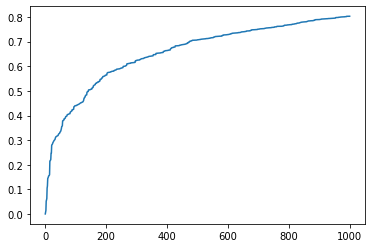

In [75]:
by_app_joined_dt.reset_index().loc[0:1000, 'impression_running_sov'].plot()

/Users/daniel.ryu/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:title={'center':'Number of Exchanges with spend by share-of-voice of top bundles'}, xlabel='exchanges'>

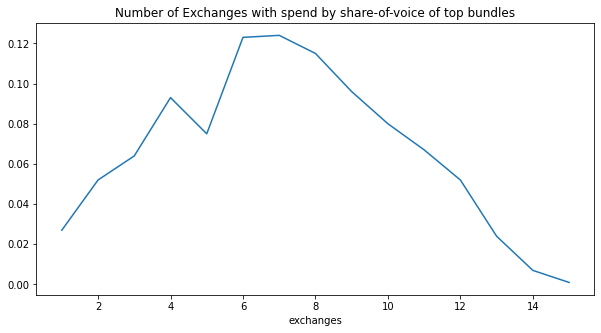

In [76]:
exchanges_cnt = by_app_joined[:1000].pivot_table(values = [('spend','Total')], index = 'exchanges', aggfunc = ['count'])
exchanges_cnt.columns = ['bundles']
exchanges_cnt['sov'] = exchanges_cnt['bundles']/exchanges_cnt['bundles'].sum()
exchanges_cnt['sov'].plot(figsize = (10,5), title = 'Number of Exchanges with spend by share-of-voice of top bundles')

/Users/daniel.ryu/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:title={'center':'Number of Exchanges with spend by share-of-voice of top bundles (DT only)'}, xlabel='exchanges'>

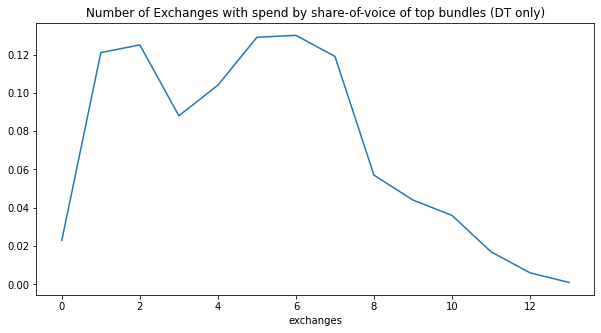

In [77]:
exchanges_cnt = by_app_joined_dt[:1000].pivot_table(values = [('spend','Total')], index = 'exchanges', aggfunc = ['count'])
exchanges_cnt.columns = ['bundles']
exchanges_cnt['sov'] = exchanges_cnt['bundles']/exchanges_cnt['bundles'].sum()
exchanges_cnt['sov'].plot(figsize = (10,5), title = 'Number of Exchanges with spend by share-of-voice of top bundles (DT only)')

In [78]:
pvt = df_size_bnd_overlap.pivot_table(values = 'spend', index = 'bundle', columns = 'exchange_name', aggfunc = np.sum, margins = True)
pvt.sort_values('All', ascending = False, inplace = True)
overlap_bybnd = 100*pvt.div(pvt.iloc[:,-1], axis=0)[1:] # Remove the "All" row
color_format(overlap_bybnd.loc[top_bundles, top_exchanges],'{:.0f}%')

In [79]:
pvt = df_size_bnd_overlap[df_size_bnd_overlap.buyer == 'DT'].pivot_table(values = 'spend', index = 'bundle', columns = 'exchange_name', aggfunc = np.sum, margins = True)
pvt.sort_values('All', ascending = False, inplace = True)
overlap_bybnd_dt = 100*pvt.div(pvt.iloc[:,-1], axis=0)[1:] # Remove the "All" row
top_exchange_cols = overlap_bybnd_dt.columns[[x in top_exchanges_dt for x in overlap_bybnd_dt.columns]]
color_format(overlap_bybnd_dt.loc[top_bundles_dt, top_exchange_cols],'{:.0f}%')

In [80]:
col_order = [('ipm',x) for x in overlap_bybnd[top_exchanges].columns]
ipms_byexchange = by_app_joined.loc[top_bundles]

def null_low_imps(r, e):
    if r[('impressions',e)] < 500000:
        return np.nan
    else:
        return r[('ipm',e)]

for e in top_exchanges:
    ipms_byexchange[('ipm', e)] = ipms_byexchange.apply(lambda x:null_low_imps(x, e), axis = 1)

ipms_byexchange = ipms_byexchange.loc[:,col_order]
ipms_byexchange.columns = [x[1] for x in by_app_joined[col_order]]

color_format(ipms_byexchange, '{:.2f}')


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


In [81]:
col_order = [('ipm',x) for x in overlap_bybnd[top_exchanges_dt].columns]
ipms_byexchange_dt = by_app_joined_dt.loc[top_bundles_dt]

def null_low_imps(r, e):
    if r[('impressions',e)] < 500000:
        return np.nan
    else:
        return r[('ipm',e)]

for e in top_exchanges_dt:
    ipms_byexchange_dt[('ipm', e)] = ipms_byexchange_dt.apply(lambda x:null_low_imps(x, e), axis = 1)

ipms_byexchange_dt = ipms_byexchange_dt.loc[:,col_order]
ipms_byexchange_dt.columns = [x[1] for x in by_app_joined_dt[col_order]]

color_format(ipms_byexchange_dt.loc[:,top_exchange_cols], '{:.2f}')


In [82]:
col_order = [('ctr',x) for x in overlap_bybnd[top_exchanges].columns]
ctrs_byexchange = by_app_joined.loc[top_bundles]

def null_low_imps(r, e):
    if r[('impressions',e)] < 500000:
        return np.nan
    else:
        return r[('ctr',e)]

for e in top_exchanges:
    ctrs_byexchange[('ctr', e)] = ctrs_byexchange.apply(lambda x:null_low_imps(x, e), axis = 1)

ctrs_byexchange = ctrs_byexchange.loc[:,col_order]
ctrs_byexchange.columns = [x[1] for x in by_app_joined[col_order]]

color_format(100*ctrs_byexchange,'{:.1f}%')

In [83]:
col_order = [('ctr',x) for x in overlap_bybnd[top_exchanges_dt].columns]
ctrs_byexchange_dt = by_app_joined_dt.loc[top_bundles_dt]

def null_low_imps(r, e):
    if r[('impressions',e)] < 500000:
        return np.nan
    else:
        return r[('ctr',e)]

for e in top_exchanges_dt:
    ctrs_byexchange_dt[('ctr', e)] = ctrs_byexchange_dt.apply(lambda x:null_low_imps(x, e), axis = 1)

ctrs_byexchange_dt = ctrs_byexchange_dt.loc[:,col_order]
ctrs_byexchange_dt.columns = [x[1] for x in by_app_joined_dt[col_order]]

color_format(100*ctrs_byexchange_dt.loc[:,top_exchange_cols],'{:.1f}%')

In [84]:
by_exchange_auction[by_exchange_auction.exchange_name.isin(top_exchanges)].pivot_table(values = ['impressions'], index = 'exchange_name', aggfunc = np.sum).sort_values('impressions', ascending = False)

impressions
exchange_name             
MoPub            333399248
Fyber            268455296
AppLovin         205783248
PubNative        146927344
Smaato            60152928
InMobi            29340624
Unity             16675840
Algorix           16666784
Chartboost         7675104
Samsung            6676864

In [85]:
last_min_exchanges = 16
df_exchange_summary = pd.DataFrame()
for min_exchanges in list(range(1, last_min_exchanges)):
    filters = by_app_joined.exchanges >= min_exchanges
    exchange_summary = []

    for e in top_exchanges:
        exchange_summary.append(by_app_joined.loc[filters, [('impressions',e),('clicks',e),('installs',e),('spend',e),('cost',e)]].sum().to_list())

    df_sub = pd.DataFrame(exchange_summary, index = top_exchanges, columns = ['impressions','clicks','installs','spend','cost'])
    df_sub[f'ctr_{min_exchanges}'] = df_sub['clicks']/df_sub['impressions']
    df_sub[f'ir_{min_exchanges}'] = df_sub['installs']/df_sub['clicks']
    df_sub[f'ipm_{min_exchanges}'] = df_sub['installs']/df_sub['impressions']*1000
    if df_exchange_summary.empty:
        df_exchange_summary = df_sub.loc[top_exchanges, [f'ctr_{min_exchanges}',f'ir_{min_exchanges}',f'ipm_{min_exchanges}']]
    else:
        df_exchange_summary = df_exchange_summary.join(df_sub.loc[top_exchanges, [f'ctr_{min_exchanges}',f'ir_{min_exchanges}',f'ipm_{min_exchanges}']], how = 'outer')

cols_ctr = [f'ctr_{x}' for x in list(range(1,last_min_exchanges))]
cols_ir = [f'ir_{x}' for x in list(range(1,last_min_exchanges))]
cols_ipm = [f'ipm_{x}' for x in list(range(1,last_min_exchanges))]
color_format(100*df_exchange_summary.loc[:,cols_ctr],"{:.1f}%")


In [86]:

color_format(100*df_exchange_summary.loc[:,cols_ir],"{:.1f}%")

In [87]:

color_format(df_exchange_summary.loc[:,cols_ipm],"{:.2f}")

In [88]:
min_impressions = 0

imp_top_exchange_cols = by_app_joined.columns[[(x[0] == 'impressions') & (x[1] in (top_exchanges + ['AdColony'])) for x in by_app_joined.columns]] 
imp_top_exchange_bundle = by_app_joined.loc[:, imp_top_exchange_cols]
imp_top_exchange_bundle.columns = [x[1] for x in imp_top_exchange_bundle.columns]
exchange_imp_overlap = pd.DataFrame()
uniq_bundle_summary = pd.DataFrame()

for i in range(len(imp_top_exchange_cols)):
    e1 = imp_top_exchange_cols[i][1]
    uniq_df = imp_top_exchange_bundle.loc[imp_top_exchange_bundle[e1] >= min_impressions]
    
    exchange_imp_overlap.at['*Total',e1] = uniq_df[e1].count()
    uniq_bundle_summary.at[e1,'total_bundle_count'] = uniq_df[e1].count()
    
    for j in range(len(imp_top_exchange_cols)):
        e2 = imp_top_exchange_cols[j][1]
        
        # computing overlap if we haven't yet
        if j >= i+1:
            overlap_df = imp_top_exchange_bundle.loc[(imp_top_exchange_bundle[e1] >= min_impressions) & (imp_top_exchange_bundle[e2] >= min_impressions),e1]  
            exchange_imp_overlap.at[e1,e2] = overlap_df.count()
            exchange_imp_overlap.at[e2,e1] = overlap_df.count()
        
        # filtering for uniques for all other columns:
        if j != i:
            uniq_df = uniq_df.loc[uniq_df[e2].isna()]

    exchange_imp_overlap.at[e1,e1] = uniq_df[e1].count()
    uniq_bundle_summary.at[e1,'exclusive_bundle_count'] = uniq_df[e1].count()
    
color_format(exchange_imp_overlap.loc[top_exchanges + ['AdColony','*Total'], top_exchanges + ['AdColony']], "{:.0f}")

# self-to-self (i.e. Mopub x Mopub) = unique bundles without min impressions on other exchanges
# self-to-other (i.e. Mopub x Fyber) = bundles with min impressions on at least these two exchanges

In [89]:
min_impressions = 0

imp_top_exchange_cols = by_app_joined_dt.columns[[(x[0] == 'impressions') & (x[1] in (top_exchanges_dt + ['AdColony'])) for x in by_app_joined_dt.columns]] 
imp_top_exchange_bundle_dt = by_app_joined_dt.loc[:, imp_top_exchange_cols]
imp_top_exchange_bundle_dt.columns = [x[1] for x in imp_top_exchange_bundle_dt.columns]
exchange_imp_overlap_dt = pd.DataFrame()
uniq_bundle_summary_dt = pd.DataFrame()

for i in range(len(imp_top_exchange_cols)):
    e1 = imp_top_exchange_cols[i][1]
    uniq_df = imp_top_exchange_bundle_dt.loc[imp_top_exchange_bundle_dt[e1] >= min_impressions]
    
    exchange_imp_overlap_dt.at['*Total',e1] = uniq_df[e1].count()
    uniq_bundle_summary_dt.at[e1,'total_bundle_count'] = uniq_df[e1].count()
    
    for j in range(len(imp_top_exchange_cols)):
        e2 = imp_top_exchange_cols[j][1]
        
        # computing overlap if we haven't yet
        if j >= i+1:
            overlap_df = imp_top_exchange_bundle_dt.loc[(imp_top_exchange_bundle_dt[e1] >= min_impressions) & (imp_top_exchange_bundle_dt[e2] >= min_impressions),e1]  
            exchange_imp_overlap_dt.at[e1,e2] = overlap_df.count()
            exchange_imp_overlap_dt.at[e2,e1] = overlap_df.count()
        
        # filtering for uniques for all other columns:
        if j != i:
            uniq_df = uniq_df.loc[uniq_df[e2].isna()]
    exchange_imp_overlap_dt.at[e1,e1] = uniq_df[e1].count()
    uniq_bundle_summary_dt.at[e1,'exclusive_bundle_count'] = uniq_df[e1].count()
    
color_format(exchange_imp_overlap_dt.loc[top_exchanges + ['AdColony','*Total'], top_exchanges + ['AdColony']], "{:.0f}")

# self-to-self (i.e. Mopub x Mopub) = unique bundles without min impressions on other exchanges
# self-to-other (i.e. Mopub x Fyber) = bundles with min impressions on at least these two exchanges

In [90]:
uniq_bundle_summary['exclusive_bundle_count'] = uniq_bundle_summary['exclusive_bundle_count'].astype('int')
uniq_bundle_summary['total_bundle_count'] = uniq_bundle_summary['total_bundle_count'].astype('int')
format_mapping = {'impressions':'{:,.0f}'
                  ,'cost':'${:,.0f}'
                  ,'spend':'${:,.0f}'
                 }
uniq_bundle_summary_joined = uniq_bundle_summary.join(by_exchange[['impressions','spend']])
uniq_bundle_summary_joined.sort_values('spend', ascending = False, inplace = True)
uniq_bundle_summary_joined = uniq_bundle_summary_joined.style.format(format_mapping)
uniq_bundle_summary_joined


In [91]:
uniq_bundle_summary_dt['exclusive_bundle_count'] = uniq_bundle_summary_dt['exclusive_bundle_count'].astype('int')
uniq_bundle_summary_dt['total_bundle_count'] = uniq_bundle_summary_dt['total_bundle_count'].astype('int')
format_mapping = {'impressions':'{:,.0f}'
                  ,'cost':'${:,.0f}'
                  ,'spend':'${:,.0f}'
                 }
uniq_bundle_summary_joined_dt = uniq_bundle_summary_dt.join(by_exchange_dt[['impressions','spend']])
uniq_bundle_summary_joined_dt.sort_values('spend', ascending = False, inplace = True)
uniq_bundle_summary_joined_dt = uniq_bundle_summary_joined_dt.style.format(format_mapping)
uniq_bundle_summary_joined_dt


In [92]:
e1 = 'Fyber'
e2 = 'Fyber'

select_cols = by_app_joined.columns[[(x[0] in ['impressions','clicks','installs','spend','cost']) & (x[1] in [e1,e2]) for x in by_app_joined.columns]]
select_df = by_app_joined.loc[(by_app_joined[('impressions',e1)] >= min_impressions) & (by_app_joined[('impressions',e2)] >= min_impressions), [x[1] in top_exchanges+['AdColony'] for x in by_app_joined.columns]]
if e1 == e2:
    for i in [x for x in select_df.columns if (x[1] != e1) & (x[0] == 'impressions')]:
        select_df = select_df.loc[select_df[i].isna()]
select_df.loc[:, select_cols].sort_values(select_cols[3], ascending = False)

#validation


(impressions, Fyber)  (clicks, Fyber)  \
bundle                                                                   
1490440004                                      784.0            160.0   
479280326                                     32368.0           3856.0   
de.tvsmiles.app                                4304.0            576.0   
com.iwaredesigns.prodarts                      1872.0             64.0   
com.spilgames.OperateNow2                      1184.0            272.0   
...                                               ...              ...   
1535463389                                     1136.0            272.0   
1536540315                                      608.0             16.0   
1535976232                                       16.0              0.0   
1537500221                                       16.0              0.0   
com.boombitgames.TinyGladiators                  32.0              0.0   

                                 (installs, Fyber)  (spend, Fyber)  \
bundle                                                               
1490440004                                    16.0           160.0   
479280326                                     16.0           160.0   
de.tvsmiles.app                               16.0            80.0   
com.iwaredesigns.prodarts                     16.0            32.0   
com.spilgames.OperateNow2                     16.0            24.0   
...                                            ...             ...   
1535463389                                     0.0             0.0   
1536540315                                     0.0             0.0   
1535976232                                     0.0             0.0   
1537500221                                     0.0             0.0   
com.boombitgames.TinyGladiators                0.0             0.0   

                                 (cost, Fyber)  
bundle                                          
1490440004                            9.874357  
479280326                           142.210973  
de.tvsmiles.app                       3.656775  
com.iwaredesigns.prodarts             8.642164  
com.spilgames.OperateNow2             5.842940  
...                                        ...  
1535463389                            8.263158  
1536540315                            1.700513  
1535976232                            0.001428  
1537500221                            0.269881  
com.boombitgames.TinyGladiators       0.486167  

[301 rows x 5 columns]

In [93]:
e1 = 'Smaato'
e2 = 'MoPub'

select_cols = by_app_joined_dt.columns[[(x[0] in ['impressions','clicks','installs','spend','cost']) & (x[1] in [e1,e2]) for x in by_app_joined_dt.columns]]
select_df = by_app_joined_dt.loc[(by_app_joined_dt[('impressions',e1)] >= min_impressions) & (by_app_joined_dt[('impressions',e2)] >= min_impressions), [x[1] in top_exchanges_dt+['AdColony'] for x in by_app_joined_dt.columns]]
if e1 == e2:
    for i in [x for x in select_df.columns if (x[1] != e1) & (x[0] == 'impressions')]:
        select_df = select_df.loc[select_df[i].isna()]
select_df.loc[:, select_cols].sort_values(select_cols[3], ascending = False)

#validation


(impressions, Smaato)  \
bundle                                                          
com.tripledot.solitaire                             2190208.0   
com.handmark.expressweather                          310976.0   
mobi.ifunny                                         6992000.0   
com.peoplefun.wordcross                              674448.0   
com.enflick.android.TextNow                          964064.0   
...                                                       ...   
com.datpiff.mobile                                   128016.0   
com.fivemobile.thescore                               12208.0   
com.hld.anzenbokusufake                                  80.0   
com.kathleenOswald.solitaireGooglePlay                34752.0   
com.betmines                                             16.0   

                                        (clicks, Smaato)  (installs, Smaato)  \
bundle                                                                         
com.tripledot.solitaire                            640.0               928.0   
com.handmark.expressweather                       3552.0               704.0   
mobi.ifunny                                       6560.0               256.0   
com.peoplefun.wordcross                             48.0               192.0   
com.enflick.android.TextNow                       3808.0               160.0   
...                                                  ...                 ...   
com.datpiff.mobile                                  32.0                 0.0   
com.fivemobile.thescore                             80.0                 0.0   
com.hld.anzenbokusufake                              0.0                 0.0   
com.kathleenOswald.solitaireGooglePlay              32.0                 0.0   
com.betmines                                         0.0                 0.0   

                                        (spend, Smaato)  (cost, Smaato)  \
bundle                                                                    
com.tripledot.solitaire                          3344.0     2191.810037   
com.handmark.expressweather                      1504.0     1145.066044   
mobi.ifunny                                       752.0     1105.118982   
com.peoplefun.wordcross                           544.0      521.953584   
com.enflick.android.TextNow                       432.0      762.997718   
...                                                 ...             ...   
com.datpiff.mobile                                  0.0       61.856218   
com.fivemobile.thescore                             0.0       13.258470   
com.hld.anzenbokusufake                             0.0        0.070626   
com.kathleenOswald.solitaireGooglePlay              0.0       16.594915   
com.betmines                                        0.0        0.001344   

                                        (impressions, MoPub)  (clicks, MoPub)  \
bundle                                                                          
com.tripledot.solitaire                               3568.0             16.0   
com.handmark.expressweather                         281472.0            784.0   
mobi.ifunny                                        6493888.0           2768.0   
com.peoplefun.wordcross                             310832.0           4320.0   
com.enflick.android.TextNow                        2752192.0          13056.0   
...                                                      ...              ...   
com.datpiff.mobile                                  107184.0            560.0   
com.fivemobile.thescore                             197040.0            528.0   
com.hld.anzenbokusufake                              12928.0             80.0   
com.kathleenOswald.solitaireGooglePlay               39568.0            128.0   
com.betmines                                          8848.0             16.0   

                                        (installs, MoPub)  (spend, MoPub)  \
bundle                                        

## 5. % of inventory coming as first price?

In [96]:
first_price = bigquery_client.query(f"""
select
    round(bid_price/settlement_price,3) as price_diff
    , auction_type
    , exchange_id
    , case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , round(bid_price,3) as bid_price
    , round(settlement_price,3) as settlement_price
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
from stats.rows attr
where
    attr.date >= '{start_dt}'
    and attr.date <= '{end_dt}'
    and left(attr.id,1) = '0'
group by 1,2,3,4,5,6
order by 1
""").to_dataframe()

In [97]:
first_price = first_price.set_index('exchange_id').join(exchange_ids.set_index('exchange_id'), how = 'left')
first_price.reset_index(inplace = True)
first_price['first_price_diff'] = abs(first_price['bid_price']/first_price['settlement_price']-1) < .01
first_price

exchange_id  price_diff  auction_type buyer  bid_price  \
0                 1.0       0.890           2.0   RON      0.020   
1                 1.0       0.893           2.0   RON      0.021   
2                 1.0       0.893           2.0   RON      0.021   
3                 1.0       0.893           2.0   RON      0.024   
4                 1.0       0.894           2.0   RON      0.021   
...               ...         ...           ...   ...        ...   
10242475         59.0    3349.296           1.0    DT     33.493   
10242476         59.0    3743.362           1.0    DT     37.434   
10242477         59.0    5245.913           1.0    DT     52.459   
10242478         59.0    5448.660           1.0    DT     54.487   
10242479          NaN         NaN           NaN   RON        NaN   

          settlement_price  impressions  spend exchange_name  first_price_diff  
0                    0.023           16    0.0         Fyber             False  
1                    0.023           16    0.0         Fyber             False  
2                    0.024           16    0.0         Fyber             False  
3                    0.027           16    0.0         Fyber             False  
4                    0.023           16    0.0         Fyber             False  
...                    ...          ...    ...           ...               ...  
10242475             0.010            0    0.0       Samsung             False  
10242476             0.010            0    0.0       Samsung             False  
10242477             0.010            0    0.0       Samsung             False  
10242478             0.010            0   32.0       Samsung             False  
10242479               NaN            0    0.0           NaN             False  

[10242480 rows x 10 columns]

In [98]:
fp_pivot = first_price.pivot_table(values = ['impressions','spend'], index = ['auction_type','first_price_diff'], aggfunc = np.sum)
fp_pivot['impression_sov'] = 100*fp_pivot['impressions']/fp_pivot.groupby('auction_type')['impressions'].sum()
fp_pivot['spend_sov'] = 100*fp_pivot['spend']/fp_pivot.groupby('auction_type')['spend'].sum()
format_mapping = {'spend':'${:,.0f}'
                 ,'impression_sov':'{:,.0f}%'
                 ,'spend_sov':'{:,.0f}%'
                 }
fp_pivot_formatted = fp_pivot.style.format(format_mapping)

fp_pivot_formatted

In [99]:
fp_pivot_dt = first_price[first_price.buyer == 'DT'].pivot_table(values = ['impressions','spend'], index = ['auction_type','first_price_diff'], aggfunc = np.sum)
fp_pivot_dt['impression_sov'] = 100*fp_pivot_dt['impressions']/fp_pivot_dt.groupby('auction_type')['impressions'].sum()
fp_pivot_dt['spend_sov'] = 100*fp_pivot_dt['spend']/fp_pivot_dt.groupby('auction_type')['spend'].sum()
format_mapping = {'spend':'${:,.0f}'
                 ,'impression_sov':'{:,.0f}%'
                 ,'spend_sov':'{:,.0f}%'
                 }
fp_pivot_dt_formatted = fp_pivot_dt.style.format(format_mapping)

fp_pivot_dt_formatted

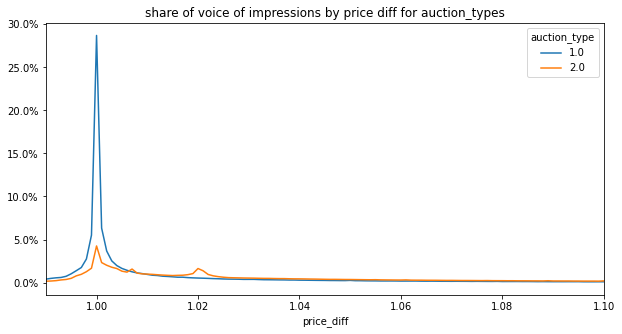

In [100]:
by_pricediff_imps = first_price.pivot_table(values = 'impressions', index = 'price_diff', columns = 'auction_type', aggfunc = np.sum, margins = True)
by_pricediff_sov = 100*by_pricediff_imps.div(by_pricediff_imps.iloc[-1], axis = 1).iloc[:-1,:2]
ax = by_pricediff_sov.plot(figsize = (10,5), xlim = (.99,1.1), title = 'share of voice of impressions by price diff for auction_types')
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

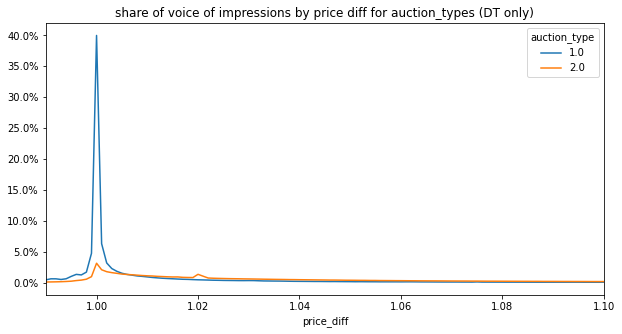

In [101]:
by_pricediff_imps_dt = first_price[first_price.buyer == 'DT'].pivot_table(values = 'impressions', index = 'price_diff', columns = 'auction_type', aggfunc = np.sum, margins = True)
by_pricediff_sov_dt = 100*by_pricediff_imps_dt.div(by_pricediff_imps_dt.iloc[-1], axis = 1).iloc[:-1,:2]
ax = by_pricediff_sov_dt.plot(figsize = (10,5), xlim = (.99,1.1), title = 'share of voice of impressions by price diff for auction_types (DT only)')
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [102]:
fp_byexchange = first_price.pivot_table(values = ['impressions','spend'], index = 'exchange_name', columns = 'auction_type', aggfunc = np.sum, margins = True)
fp_byexchange.columns = ['first_price_impressions','second_price_impressions','total_impressions','first_price_spend','second_price_spend','total_spend']
fp_byexchange['total_impressions'] = fp_byexchange['first_price_impressions'].fillna(0) + fp_byexchange['second_price_impressions'].fillna(0) 
fp_byexchange['pct_imps_first_price'] = 100*fp_byexchange['first_price_impressions']/fp_byexchange['total_impressions']
fp_byexchange['pct_spend_first_price'] = 100*fp_byexchange['first_price_spend']/fp_byexchange['total_spend']
fp_byexchange.sort_values('total_impressions', ascending = False, inplace = True)

format_mapping = {'first_price_impressions':'{:,.0f}'
                 ,'second_price_impressions':'{:,.0f}'
                 ,'total_impressions':'{:,.0f}'
                 ,'pct_imps_first_price':'{:,.0f}%'
                 ,'pct_spend_first_price':'{:,.0f}%'
                 ,'first_price_spend':'${:,.0f}'
                 ,'second_price_spend':'${:,.0f}'
                 ,'total_spend':'${:,.0f}'
                 }

fp_byexchange_formatted = fp_byexchange[['total_impressions', 'pct_imps_first_price', 'total_spend', 'pct_spend_first_price']].fillna(0)
fp_byexchange_formatted = fp_byexchange_formatted.style.format(format_mapping)
fp_byexchange_formatted

In [103]:
fp_byexchange = first_price[first_price.buyer == 'DT'].pivot_table(values = ['impressions','spend'], index = 'exchange_name', columns = 'auction_type', aggfunc = np.sum, margins = True)
fp_byexchange.columns = ['first_price_impressions','second_price_impressions','total_impressions','first_price_spend','second_price_spend','total_spend']
fp_byexchange['total_impressions'] = fp_byexchange['first_price_impressions'].fillna(0) + fp_byexchange['second_price_impressions'].fillna(0) 
fp_byexchange['pct_imps_first_price'] = 100*fp_byexchange['first_price_impressions']/fp_byexchange['total_impressions']
fp_byexchange['pct_spend_first_price'] = 100*fp_byexchange['first_price_spend']/fp_byexchange['total_spend']
fp_byexchange.sort_values('total_impressions', ascending = False, inplace = True)

format_mapping = {'first_price_impressions':'{:,.0f}'
                 ,'second_price_impressions':'{:,.0f}'
                 ,'total_impressions':'{:,.0f}'
                 ,'pct_imps_first_price':'{:,.0f}%'
                 ,'pct_spend_first_price':'{:,.0f}%'
                 ,'first_price_spend':'${:,.0f}'
                 ,'second_price_spend':'${:,.0f}'
                 ,'total_spend':'${:,.0f}'
                 }

fp_byexchange_formatted = fp_byexchange[['total_impressions', 'pct_imps_first_price', 'total_spend', 'pct_spend_first_price']].fillna(0)
fp_byexchange_formatted = fp_byexchange_formatted.style.format(format_mapping)
fp_byexchange_formatted

## 6. % of Bid Requests/Spend from LAT vs Non LAT

In [105]:
lat_df = bigquery_client.query(f"""
select
    no_ifa as LAT
    , case when platform = 1 then 'Android'
    else 'iOS' end as platform
    , case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , count(distinct attr.id)*16 as impressions
    , (sum(case when event_type = 'clear' then settlement_price else 0 end)/1000)*16 as cost
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
from stats.rows attr 
where
    left(attr.id,1) = '0'
    and date >= '{start_dt}'
    and date <= '{end_dt}'
group by 1,2,3
""").to_dataframe()

In [106]:
by_lat = lat_df.groupby(['LAT'])['impressions','cost','spend'].sum()
by_lat['cpm'] = 1000*by_lat['cost']/by_lat['impressions']
by_lat['profit'] = by_lat['spend'] - by_lat['cost']
by_lat['margin'] = by_lat['profit']/by_lat['spend']
by_lat['impression_sov'] = by_lat['impressions']/by_lat['impressions'].sum()
by_lat['spend_sov'] = by_lat['spend']/by_lat['spend'].sum()
by_lat['cost_sov'] = by_lat['cost']/by_lat['cost'].sum()

by_lat_formatted = by_lat[['impressions','impression_sov','cost','cost_sov','cpm','spend','spend_sov','profit','margin']]
by_lat_formatted[['impression_sov','spend_sov','cost_sov','margin']] = by_lat_formatted[['impression_sov','spend_sov','cost_sov','margin']].mul(100)
format_mapping = {'impressions':'{:,}'
                 , 'impression_sov':'{:.0f}%'
                 , 'cost_sov':'{:.0f}%'
                 , 'spend_sov':'{:.0f}%'
                 , 'margin':'{:.0f}%'
                 , 'cost':'${:,.0f}'
                 , 'spend':'${:,.0f}'
                 , 'profit':'${:,.0f}'
                 , 'cpm':'${:,.2f}'
                 }
by_lat_formatted = by_lat_formatted.style.format(format_mapping)
by_lat_formatted

<ipython-input-106-f4f2b16c6a40>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_lat = lat_df.groupby(['LAT'])['impressions','cost','spend'].sum()


In [107]:
by_lat_dt = lat_df[lat_df.buyer == 'DT'].groupby(['LAT'])['impressions','cost','spend'].sum()
by_lat_dt['cpm'] = 1000*by_lat_dt['cost']/by_lat_dt['impressions']
by_lat_dt['profit'] = by_lat_dt['spend'] - by_lat_dt['cost']
by_lat_dt['margin'] = by_lat_dt['profit']/by_lat_dt['spend']
by_lat_dt['impression_sov'] = by_lat_dt['impressions']/by_lat_dt['impressions'].sum()
by_lat_dt['spend_sov'] = by_lat_dt['spend']/by_lat_dt['spend'].sum()
by_lat_dt['cost_sov'] = by_lat_dt['cost']/by_lat_dt['cost'].sum()

by_lat_dt_formatted = by_lat_dt[['impressions','impression_sov','cost','cost_sov','cpm','spend','spend_sov','profit','margin']]
by_lat_dt_formatted[['impression_sov','spend_sov','cost_sov','margin']] = by_lat_dt_formatted[['impression_sov','spend_sov','cost_sov','margin']].mul(100)
format_mapping = {'impressions':'{:,}'
                 , 'impression_sov':'{:.0f}%'
                 , 'cost_sov':'{:.0f}%'
                 , 'spend_sov':'{:.0f}%'
                 , 'margin':'{:.0f}%'
                 , 'cost':'${:,.0f}'
                 , 'spend':'${:,.0f}'
                 , 'profit':'${:,.0f}'
                 , 'cpm':'${:,.2f}'
                 }
by_lat_dt_formatted = by_lat_dt_formatted.style.format(format_mapping)
by_lat_dt_formatted

<ipython-input-107-dbffb0a08672>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_lat_dt = lat_df[lat_df.buyer == 'DT'].groupby(['LAT'])['impressions','cost','spend'].sum()


In [108]:
by_lat_platform = lat_df.groupby(['platform','LAT'])['impressions','cost','spend'].sum()
by_lat_platform['cpm'] = 1000*by_lat_platform['cost']/by_lat_platform['impressions']
by_lat_platform['profit'] = by_lat_platform['spend'] - by_lat_platform['cost']
by_lat_platform['margin'] = by_lat_platform['profit']/by_lat_platform['spend']
by_lat_platform['impression_sov'] = by_lat_platform['impressions']/by_lat_platform.groupby('platform')['impressions'].sum()
by_lat_platform['spend_sov'] = by_lat_platform['spend']/by_lat_platform.groupby('platform')['spend'].sum()
by_lat_platform['cost_sov'] = by_lat_platform['cost']/by_lat_platform.groupby('platform')['cost'].sum()
by_lat_platform.sort_index(inplace = True)

by_lat_platform_formatted = by_lat_platform[['impressions','impression_sov','cost','cost_sov','cpm','spend','spend_sov','profit','margin']]
by_lat_platform_formatted[['impression_sov','spend_sov','cost_sov','margin']] = by_lat_platform_formatted[['impression_sov','spend_sov','cost_sov','margin']].mul(100)
format_mapping = {'impressions':'{:,}'
                 , 'impression_sov':'{:.0f}%'
                 , 'cost_sov':'{:.0f}%'
                 , 'spend_sov':'{:.0f}%'
                 , 'margin':'{:.0f}%'
                 , 'cost':'${:,.0f}'
                 , 'spend':'${:,.0f}'
                 , 'profit':'${:,.0f}'
                 , 'cpm':'${:,.2f}'
                 }
by_lat_platform_formatted = by_lat_platform_formatted.style.format(format_mapping)
by_lat_platform_formatted

<ipython-input-108-87cabf5d6c1b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_lat_platform = lat_df.groupby(['platform','LAT'])['impressions','cost','spend'].sum()


In [109]:
by_lat_platform_dt = lat_df[lat_df.buyer == 'DT'].set_index(['platform','LAT'])
by_lat_platform_dt['cpm'] = 1000*by_lat_platform_dt['cost']/by_lat_platform_dt['impressions']
by_lat_platform_dt['profit'] = by_lat_platform_dt['spend'] - by_lat_platform_dt['cost']
by_lat_platform_dt['margin'] = by_lat_platform_dt['profit']/by_lat_platform_dt['spend']
by_lat_platform_dt['impression_sov'] = by_lat_platform_dt['impressions']/by_lat_platform_dt.groupby('platform')['impressions'].sum()
by_lat_platform_dt['spend_sov'] = by_lat_platform_dt['spend']/by_lat_platform_dt.groupby('platform')['spend'].sum()
by_lat_platform_dt['cost_sov'] = by_lat_platform_dt['cost']/by_lat_platform_dt.groupby('platform')['cost'].sum()
by_lat_platform_dt.sort_index(inplace = True)

by_lat_platform_dt_formatted = by_lat_platform_dt[['impressions','impression_sov','cost','cost_sov','cpm','spend','spend_sov','profit','margin']]
by_lat_platform_dt_formatted[['impression_sov','spend_sov','cost_sov','margin']] = by_lat_platform_dt_formatted[['impression_sov','spend_sov','cost_sov','margin']].mul(100)
format_mapping = {'impressions':'{:,}'
                 , 'impression_sov':'{:.0f}%'
                 , 'cost_sov':'{:.0f}%'
                 , 'spend_sov':'{:.0f}%'
                 , 'margin':'{:.0f}%'
                 , 'cost':'${:,.0f}'
                 , 'spend':'${:,.0f}'
                 , 'profit':'${:,.0f}'
                 , 'cpm':'${:,.2f}'
                 }
by_lat_platform_dt_formatted = by_lat_platform_dt_formatted.style.format(format_mapping)
by_lat_platform_dt_formatted

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [110]:
lat_byday = bigquery_client.query(f"""
select
    date
    , no_ifa as LAT
    , case when platform = 1 then 'Android'
    else 'iOS' end as platform
    , case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , count(distinct attr.id)*16 as impressions
from stats.rows attr
where
    left(attr.id,1) = '0'
    and date >= '2021-01-01'
    and date <= '{end_dt}'
group by 1,2,3,4
""").to_dataframe()

In [111]:
lat_byday.date = lat_byday.date.astype('datetime64')

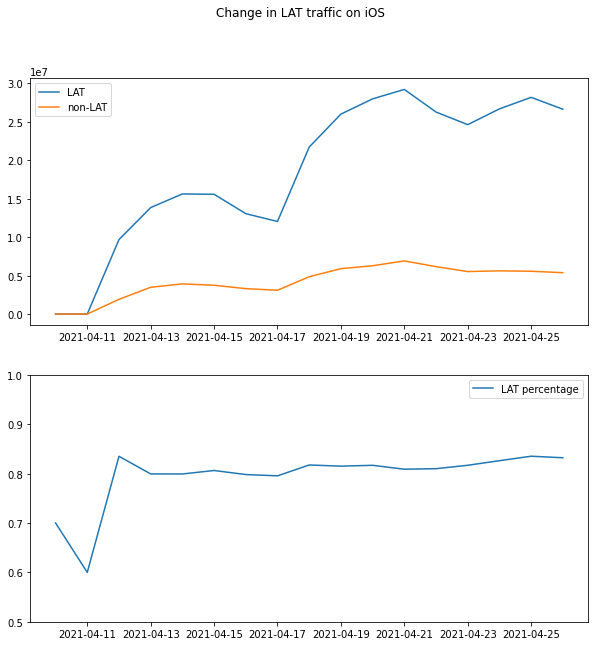

In [112]:
ios_lat_byday = lat_byday[lat_byday.platform == 'iOS'].pivot_table(values = 'impressions', index = 'date', columns = 'LAT', aggfunc = np.sum)
ios_lat_byday['lat_pct'] = ios_lat_byday[1]/(ios_lat_byday[1] + ios_lat_byday[0])
fig, ax = plt.subplots(2,1, figsize = (10,10))
fig.suptitle('Change in LAT traffic on iOS')
ax[0].plot(ios_lat_byday[[1,0]])
ax[0].legend(['LAT','non-LAT'])
ax[1].set_ylim(0.5,1)
ax[1].plot(ios_lat_byday[['lat_pct']])
ax[1].legend(['LAT percentage'])